This code: *Hendrik Scheewel* (hendrik.scheewel@uliege.be)

Joint project with: *Frédéric Docquier*, *Michał Burzyński*

# Load packages

In [1]:
# import packages
import datetime
import io
import itertools
import math
from itertools import cycle
from string import ascii_lowercase as abc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
import seaborn as sns
import statsmodels.formula.api as sm
from IPython.display import HTML
from matplotlib import rcParams
from numba import float64, guvectorize, jit, njit, vectorize
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

sns.set_palette('Paired')
colors = sns.color_palette()
sns.set()
sns.set(style="white")
rcParams['font.family'] = 'monospace'

In [2]:
R = ('a', 'n')                      # regions
S = ('l', 'h')                      # skills
B = ('d', 'f')                      # areas
T = (1980, 2010, 2040, 2070, 2100)  # periods of interest
t0 = 1950                           # first period

# Simulation class

In [3]:
class model:
    def __init__(self,
                 name, # name of the model instance
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 χ={'d': 0.0, 'f': 0.5}, # income loss due to forced discplacement
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='inputs.xlsx', # input of data
                 scenario='intermediate'): # climate change scenario
        
        self.σ, self.τ, self.μ, self.χ, self.tol  = σ, τ, μ, χ, tol
        
        self.name = name
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim)))).sort_index()

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']
        data_irsbt.index.name = 'Country'
        # irsbt = origin-destination-region-skill-time-specific
        data_ijrst = get_input(inputs, 'ijrsbt') 
        data_ijrst.columns.names = ['Variable','r','s','b','t','Destination']
        data_ijrst.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.bddm = data_i['bddm'] # BDDM regions
        self.latitude = data_i['latitude'] # Latitude
        self.Y = data_irt['Y'] # GDP
        self.Γ__n = data_irt['Γ__n'] # high-to-low-skill fertility ratio
        self.Γ__w = data_irt['Γ__w'] # high-to-low-skill wage ratio
        self.L = data_irst['L'] # resident population
        self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.Mij = data_ijrst['Mij'] # number of emigrants
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        self.D.columns.names = ['r','t']
        
        self.ω = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['ω']
        self.ω.columns.names = ['r','t']
        
        # Geodataframe containing shape information
        self.shapes = gpd.read_file('shapes/shapes.shp').set_index('Country')
        
        # Lexsort all dataframes:
        for i in list(self.__dict__):
            if isinstance(self.__dict__[i],pd.DataFrame):
                try:
                    if self.__dict__[i].columns.is_lexsorted() == False:
                        self.__dict__[i].columns.sortlevel(inplace=True)
                except:
                    pass

In [4]:
def correct_south_south(self):
    for s in S:
        self.L[('n',s,2010)] = self.L[('n',s,2010)] +\
        (self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]) 
         + self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3])).multiply(1-self.OECD,1).sum()
        
model.correct_south_south = correct_south_south

In [5]:
def MidxDataFrame(self,dim,value=np.nan):
    """ Creates multi-indexed empty dataframe with country-index"""
    
    MultiIndexDic = {
    'irt': {
        'levels': [R,T],
        'names': ['r','t'],
    },
    'ist': {
        'levels': [S,T],
        'names': ['s','t'],
    },
    'irs': {
        'levels': [R,S],
        'names': ['r','s'],
    },
    'irst': {
        'levels': [R,S,T],
        'names': ['r','s','t'],
    },
    'irsbt': {
        'levels': [R,S,B,T],
        'names': ['r','s','b','t'],
    },
    'ijrs': {
        'levels': [R,S,list(self.countries)],
        'names': ['r','s','Destination'],
    },
    'ijrst': {
        'levels': [R,S,T,list(self.countries)],
        'names': ['r','s','t','Destination']
    },
    'ijrsbt': {
        'levels': [R,S,B,T,list(self.countries)],
        'names': ['r','s','b','t','Destination']
    },
    'ijrsft': {
        'levels': [R,S,['f'],T,list(self.countries)],
        'names': ['r','s','b','t','Destination']}}
    
    
    return(pd.DataFrame(value, index=self.countries,
                        columns=pd.MultiIndex.from_product(
                            MultiIndexDic[dim]['levels'],
                            names=MultiIndexDic[dim]['names']).sortlevel()[0]))

model.MidxDataFrame = MidxDataFrame

## Calibration methods

### Calibration of skill-biased externality κ

In [6]:
def calib_kappa(self):
    """ Calibration of κ_n, Γ__η_bar_n"""
    self.κ = {'a': 0.0, 'n': np.nan}
    self.Γ__η_bar = {'a': 1.32558139534884, 'n': np.nan}
    self.Γ__L = self.MidxDataFrame('irt')
    self.Γ__η = self.MidxDataFrame('irt')

    def Γ__L(r, t):
        return(self.L[(r,'h',t)]/self.L[(r,'l',t)])
    
    def Γ__η_cal(r, t):
        if r == 'n':
            return(self.Γ__w[(r,t)] * self.Γ__L[(r,t)]**(1/self.σ[r]))
        else:
            return(self.Γ__η_bar[r])
    
    for t in [1980,2010]:
        for r in R:
            self.Γ__L[(r,t)] = Γ__L(r, t)
            self.Γ__η[(r,t)] = Γ__η_cal(r, t)

    t = 2010
    df = pd.DataFrame({'Γ__η': self.Γ__η[('n',t)],'Γ__L': self.Γ__L[('n',t)]})

    reg = sm.ols(formula="np.log(Γ__η) ~ np.log(Γ__L)", data=df).fit()

    self.κ['n'] = 0.5*reg.params['np.log(Γ__L)']

    self.Γ__η_bar['n'] = np.exp(reg.params['Intercept'])

model.calib_kappa = calib_kappa

### Calibration of Total factor productivity A

In [7]:
def calib_A(self):
    """ Calibration of TFP for 1980, 2010"""
    
    σ = self.σ
    self.η = self.MidxDataFrame('irst')
    self.A = self.MidxDataFrame('irt')
    
    def η_cal(r, s, t):
        ''' Relative productivity '''
        η_h = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
        if s == 'h':
            return (η_h)
        else:
            return (1 - η_h)
        
    def A_cal(r, t):
        ''' TFP '''
        if r == 'a':
            return((self.Y[(r, t)]) /
                  (self.η[(r,'l',t)] * self.L[(r,'l',t)] +
                   self.η[(r,'h',t)] * self.L[(r,'l',t)]))
        else:
            return(self.Y[(r, t)] /
                 (self.η[(r,'l',t)] * (self.L[(r,'l',t)])**((σ[r]-1)/σ[r]) +
                  self.η[(r,'h',t)] * (self.L[(r,'l',t)])**((σ[r]-1)/σ[r]))**(σ[r]/(σ[r]-1)))
    
    for t in [1980,2010]:
        for r in R:
            for s in S:
                self.η[(r, s, t)] = η_cal(r, s, t)
        
    for t in [1980,2010]:
        for r in R:
            self.A[(r,t)] = A_cal(r, t)

model.calib_A = calib_A

### Calibration of aggregate externality ε

In [8]:
def calib_epsilon(self):
    """ Calibration of ε_r, A_bar_r for r in {a, n} """
    
    self.ε = {'a': np.nan, 'n': np.nan}             # aggregate externality
    self.A_bar = pd.DataFrame(index=self.countries) # scale factor in TFP

    df = pd.concat([self.A,self.Γ__L],1,keys=['A','Γ__L'])

    def reg(r):
        df = self.A[r].melt(var_name='year1980',value_name='A')
        df = df.join(self.Γ__L[r].melt(var_name='year1980'
                                       ,value_name='Γ__L')['Γ__L'])
        df['year1980'] = np.where(df.year1980 == 1980,1,0)
        
        reg = sm.ols(formula="np.log(A) ~ np.log(Γ__L) + year1980", 
                     data=df).fit()

        return(reg.params)

    self.γ = reg('a')['year1980'] ** (1/30)
    self.γ = 1.00256317290118    

    t = 1980
    for r in R:
        self.ε[r] = 0.5 * reg(r)['np.log(Γ__L)']
        self.A_bar[r] = self.A[(r,t)]/(self.γ * self.Γ__L[(r,t)]**self.ε[r] * self.D[(r,t)])
    
model.calib_epsilon = calib_epsilon

### Calibration of migration costs

In [9]:
def calib_migcosts(self):
    """ Calibration of migration costs """
    σ, μ = self.σ, self.μ
    τ, ε, κ, Γ__η_bar = self.τ, self.ε, self.κ, self.Γ__η_bar
    tol = self.tol
    γ = self.γ
    
    t = 2010
    
    # Create empty dataframes for emigrant to stayer ratios, stayers and migrants
    self.N = self.MidxDataFrame('irst')
    self.miF = self.MidxDataFrame('irst')
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mii = self.MidxDataFrame('irsbt')
    self.MiF = self.MidxDataFrame('irst')

    for s in S:
        v_n_s       = 1 # share of immigrants that goes to urban area
        m_an_s      = self.mii[('a',s,'d',2010)] # exog. rural internal emigrant-to-stayer ratio
        m_na_s      = 0 # urban internal emigrant-to-stayer ratio
        
        L_a_s_hat   = self.L[('a',s,2010)] # rural residents
        L_n_s_hat   = self.L[('n',s,2010)] # urban residents
        L_s_hat     = L_a_s_hat + L_n_s_hat # all residents
        
        M_aF_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(1) # rural emigrants
        M_nF_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(1) # urban emigrants
        M_F_s_hat   = M_aF_s_hat + M_nF_s_hat # all emigrants
        
        I_Fa_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(0) # rural immigrants
        I_Fn_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(0) # urban immigrants
        I_s_hat     = I_Fa_s_hat + I_Fn_s_hat # all immigrants
        
        N_s_hat     = L_s_hat + M_F_s_hat - I_s_hat # all natives

        # for all countries: internal emigrant-to-stayer ratios of high-skilled = 0.3
        if s == 'h':
            m_an_s = pd.Series(0.3,index=self.countries)
        # problematic observations: set internal emigrant to stayer ratio = 0
        if s == 'l':
            m_an_s.loc['Tonga'] = 0

        M_aa_s = L_a_s_hat - (1 - v_n_s) * I_s_hat # rural stayers = residents - immigrants
        m_aF_s = M_aF_s_hat/M_aa_s # rural internat. emigrant-to-stayer ratio
        M_nn_s = L_n_s_hat - m_an_s * M_aa_s - v_n_s * I_s_hat # urban stayers
        m_nF_s = M_nF_s_hat/M_nn_s # urban internat. emigrant-to-stayer ratio
        
        N_a_s  = M_aa_s * (1 + m_an_s + m_aF_s) # rural natives
        N_n_s  = M_nn_s * (1 + m_na_s + m_nF_s) # urban natives
        
        M_an_s = m_an_s * M_aa_s # rural internal emigrants
        M_na_s = m_na_s * M_nn_s # urban internal emigrants
        
        M_aF_s = m_aF_s * M_aa_s # rural internat. emigrants
        M_nF_s = m_nF_s * M_nn_s # urban internat. emigrants
        
        RES_a  = abs(N_a_s - (M_aa_s + M_aF_s + M_an_s)) # residual
        RES_n  = abs(N_n_s - (M_nn_s + M_nF_s + M_na_s)) # residual

        # Assign derived values to dataframes
        self.mii[('a',s,'d',t)]  = m_an_s # internal rural emigrant-to-stayer ratio
        self.mii[('n',s,'d',t)]  = m_na_s # internal urban emigrant-to-stayer ratio
        
        self.miF[('a',s,t)]      = m_aF_s # internat. rural emigrant-to-stayer ratio
        self.miF[('n',s,t)]      = m_nF_s # internat. urban emigrant-to-stayer ratio
        
        self.N[('a',s,t)]        = N_a_s  # rural natives
        self.N[('n',s,t)]        = N_n_s  # urban natives
        
        self.Ms[('a',s,'d', t)]  = M_aa_s # rural stayers
        self.Ms[('n',s,'d', t)]  = M_nn_s # urban stayers
        
        self.Mii[('a',s,'d', t)] = M_an_s # rural internal emigrants
        self.Mii[('n',s,'d', t)] = M_na_s # urban internal emigrants
        
        self.MiF[('a',s,t)]      = M_aF_s # rural internat. emigrants
        self.MiF[('n',s,t)]      = M_nF_s # urban internat. emigrants
        
    self.mij = self.MidxDataFrame('ijrsbt')
    
    
    for r in R:
        for s in S:
            self.mij[(r,s,'d',t)] = np.array(self.Mij[(r,s,'d',t)].multiply((1/self.Ms[(r,s,'d',t)]),0))

    # Create new empty dataframes for variables to derive
    self.Γ__L = self.MidxDataFrame('irt')
    self.η = self.MidxDataFrame('irst')
    self.Γ__η = self.MidxDataFrame('irt')
    self.Γ__w = self.MidxDataFrame('irt')
    self.Y = self.MidxDataFrame('irt')
    self.w = self.MidxDataFrame('irst')
    self.c = self.MidxDataFrame('irsbt')
    self.v = self.MidxDataFrame('irsbt')
    self.V = self.MidxDataFrame('ijrsbt')
    self.xii = self.MidxDataFrame('irs')
    self.xij = self.MidxDataFrame('ijrs')


    ''' Functions '''
    # Before we can pin down bilateral migration costs
    # we need to identify indirect utilities:

    def Γ__L_cal(r, t):
        ''' Skill ratio in the labor force '''
        return (self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

    def Γ__η_cal(r, t):
        ''' Skill bias in relative productivity '''
        return (Γ__η_bar[r] * self.Γ__L[(r, t)]**κ[r])

    def η_cal(r, s, t):
        ''' Relative productivity '''
        η_h = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
        if s == 'h':
            return (η_h)
        else:
            return (1 - η_h)

    def A_cal(r, t):
        ''' Total factor productivity '''
        return (γ**(t - t0) * self.D[(r, t)]
                * self.A_bar[r] * self.Γ__L[(r, t)]**ε[r])

    def Y_cal(r, t):
        ''' Gross domestic product '''
        if r == 'n':
            return(self.A[(r, t)] 
                   * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((σ[r]-1)/σ[r])
                      + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((σ[r]-1)/σ[r]))**(σ[r]/(σ[r]-1)))
        else:
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]
                                     + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))

    def w_cal(r, s, t):
        ''' Wage rate '''
        if r == 'a':
            return (η_cal(r, s, t) * self.A[(r, t)])
        if r == 'n':
            return (η_cal(r, s, t) * self.A[(r, t)] ** ((σ[r]-1)/σ[r]) 
                    * (Y_cal(r, t) / self.L[(r, s, t)])**(1 / σ[r]))

    def Γ__w_cal(r, t):
        ''' High-low-skilled wage ratio '''
        return(self.w[(r, 'h', t)]/self.w[(r, 'l', t)])

    def c_cal(r, s, b, t):
        ''' Consumption '''
        return(self.w[(r, s, t)])

    def v_cal(r, s, b, t):
        ''' Inner utility '''
        return((1 - τ[r]) * self.c[(r, s, b, t)])
    
    def V_cal(r, s, b, t):
        ''' Relative utility between two regions '''
        return(np.outer(1/self.v[(r,s,b,t)],self.v[('n',s,'d',t)]))
    
    # The following two functions are the inverse functions of mii and mij
    def xii_cal(r, s):
        ''' internal migration cost'''
        return(1 - self.mii[(r,s,b,2010)]**μ * (self.v[(r,s,'d',2010)]/self.v[('n',s,'d',2010)]))
    
    def xij_cal(r, s):
        ''' international migration cost '''
        return(np.array(1 - self.mij[(r,s,'d',2010)]**μ * (1/self.V[(r,s,'d',2010)])\
                        * (1 - np.diag(np.ones(len(self.countries))))))
    
    ########### NEW #############
    
    def mii_cal(r, s, b, t):
        ''' Internal emigrant to stayer ratio '''
        return(((self.v[('n', s, 'd', t)]/self.v[(r, s, b, t)])
                * ( (1-self.xii[(r, s)])/(1-self.χ[b])))**(1/μ))

    def mij_cal(r, s, b, t):
        ''' International emigrant to stayer ratio'''
        return(np.array(self.V[(r,s,'d',2010)]**(1/μ)\
                        * ((1-self.xij[(r,s)])/(1-self.χ[b]))**(1/μ)\
                        * (1-np.diag(np.ones(len(self.countries))))))    
    
    def Ms_cal(r, s, b, t):
        """ Stayers """
        if b == 'd':
            share = 1-self.ω[(r,t)]
        else:
            share = self.ω[(r,t)]
        return((share * self.N[(r, s, t)])/
           (1 + self.mii[(r, s, b, t)] + self.mij[(r,s,b,t)].sum(1)))
    
    def Mii_cal(r, s, b, t):
        """ Internal emigrants from dry area """
        return(self.mii[(r, s, b, t)] * self.Ms[(r, s, b, t)])

    def Mij_cal(r, s, b, t):
        """ Internal emigrants from dry area """
        return(np.array(self.mij[(r,s,b,t)].multiply(self.Ms[(r,s,b,t)],0)))
    
    ########### NEW #############
    
    b = 'd'
    t = 2010
    for r in R:
        self.Γ__L[(r, t)] = Γ__L_cal(r, t)
        self.Γ__η[(r, t)] = Γ__η_cal(r, t)
    for r in R:
        for s in S:
            self.η[(r, s, t)] = η_cal(r, s, t)
        self.A[(r, t)] = A_cal(r, t)
        self.Y[(r, t)] = Y_cal(r, t)
    for r in R:
        for s in S:
            self.w[(r, s, t)] = w_cal(r, s, t)
    for r in R:
        self.Γ__w[(r, t)] = Γ__w_cal(r, t)
    for r in R:
        for s in S:
            self.c[(r, s, b, t)] = c_cal(r, s, b, t)
            self.v[(r, s, b, t)] = v_cal(r, s, b, t)
    for r in R:
        for s in S:
            self.V.loc[:,(r, s, b, t)] = V_cal(r, s, b, t)
    t = 2010
    for r in R:
        for s in S:
            self.xii[(r, s)] = xii_cal(r,s)
            self.xij.loc[:,(r,s)] = np.array(xij_cal(r,s))
            
    Mijf = self.MidxDataFrame('ijrsft').fillna(0)
    
    self.Mij = self.Mij.join(Mijf)
    
    for r in R:
        for s in S:
            self.Mii[(r,s,'f',2010)] = 0
            
    
    ############# NEW ###############
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]

    for r in R:
        for s in S:
                self.mii[(r, s, b, t)] = mii_cal(r, s, b, t)
    for r in R:
        for s in S:
                self.mij.loc[:,(r, s, b, t)] = mij_cal(r, s, b, t)
    for r in R:
        for s in S:
                self.Ms[(r, s, b, t)]  = Ms_cal(r, s, b, t)
                self.Mii[(r, s, b, t)] = Mii_cal(r, s, b, t)
                self.Mij.loc[:,(r, s, b, t)] = Mij_cal(r, s, b, t)        
    
model.calib_migcosts = calib_migcosts

### Exogenous fertility

In [10]:
def fertility(self):

    for t in [2010,2040,2070,2100]:
        for r in R:
            for s in S:
                for b in B:
                    self.n[(r,s,b,t)] = self.n[(r,s,'d',t)]
                    self.p[(r,s,b,t)] = self.p[(r,s,'d',t)]      

model.fertility = fertility

## Simulation method

In [11]:
def simulate(self, max_iter=150, report=False, report_from=0,quickstart=False,mig_config='full'):
    """ Load  parameters """
    σ, μ= self.σ, self.μ
    τ, ε, κ, Γ__η_bar = self.τ, self.ε, self.κ, self.Γ__η_bar
    tol = self.tol
    γ = self.γ

    A_bar, xii, xij = self.A_bar, self.xii, self.xij

    t = 1980
    # Create empty dataframes
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Iii = self.MidxDataFrame('irst')
    self.Iij = self.MidxDataFrame('irst')
    
    """ Functions """

    def Γ__L_fun(r, t):
        ''' Skill ratio in the labor force '''
        return (self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

    def Γ__η_fun(r, t):
        ''' Skill bias in relative productivity '''
        return (Γ__η_bar[r] * self.Γ__L[(r, t)]**κ[r])

    def η_fun(r, s, t):
        ''' Relative productivity '''
        η_h = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
        if s == 'h':
            return (η_h)
        else:
            return (1 - η_h)

    def A_fun(r, t):
        ''' Total factor productivity '''
        return (γ**(t - t0) * self.D[(r, t)]
                * self.A_bar[r] * self.Γ__L[(r, t)]**ε[r])

    def Y_fun(r, t):
        ''' Gross domestic product '''
        if r == 'n':
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((σ[r]-1)/σ[r])
                                     + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((σ[r]-1)/σ[r]))**(σ[r]/(σ[r]-1)))
        else:
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]
                                     + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))

    def w_fun(r, s, t):
        ''' Wage rate '''
        if r == 'a':
            return (η_fun(r, s, t) * self.A[(r, t)])
        if r == 'n':
            return (η_fun(r, s, t) * self.A[(r, t)] ** ((σ[r]-1)/σ[r]) * (Y_fun(r, t) / self.L[(r, s, t)])**(1 / σ[r]))

    def Γ__w_fun(r, t):
        ''' High-low-skilled wage ratio '''
        return(self.w[(r, 'h', t)]/self.w[(r, 'l', t)])

    def c_fun(r, s, b, t):
        ''' Consumption '''
        return(self.w[(r, s, t)] )

    
    def v_fun(r, s, b, t):
        ''' Inner utility '''
        return((1 - τ[r]) * self.c[(r, s, b, t)])
    
    def V_fun(r, s, b, t):
        ''' Relative utility between two regions '''
        return(np.outer(1/self.v[(r,s,b,t)],self.v[('n',s,'d',t)]))

    def mii_fun(r, s, b, t):
        ''' Internal emigrant to stayer ratio '''
        return(((self.v[('n', s, 'd', t)]/self.v[(r, s, b, t)])
                * ( (1-self.xii[(r, s)])/(1-self.χ[b])))**(1/μ))

    def mij_fun(r, s, b, t):
        ''' International emigrant to stayer ratio'''
        return(np.array(self.V[(r,s,'d',2010)]**(1/μ)\
                        * ((1-self.xij[(r,s)])/(1-self.χ[b]))**(1/μ)\
                        * (1-np.diag(np.ones(len(self.countries))))))    
    
    def Ms_fun(r, s, b, t):
        """ Stayers """
        if b == 'd':
            share = 1-self.ω[(r,t)]
        else:
            share = self.ω[(r,t)]
        return((share * self.N[(r, s, t)])/
               (1 + self.mii[(r, s, b, t)] + self.mij[(r,s,b,t)].sum(1)))
    
    def Mii_fun(r, s, b, t):
        """ Internal emigrants from dry area """
        return(self.mii[(r, s, b, t)] * self.Ms[(r, s, b, t)])

    def Mij_fun(r, s, b, t):
        """ Internal emigrants from dry area """
        return(np.array(self.mij[(r,s,b,t)].multiply(self.Ms[(r,s,b,t)],0)))
    
    def Iii_fun(r,s,t):
        """ Internal immigrant flow"""
        rprime = set(R).difference(r).pop()
        return(self.Mii[(rprime,s,'d',t)] + self.Mii[(rprime,s,'f',t)])

    def Iij_fun(r, s, t):
        ''' International immigrant flow '''
        if r == 'a':
            return(0)
        else:
            return((self.Mij[('a',s,'d',t)] + self.Mij[('a',s,'f',t)] \
                  + self.Mij[('n',s,'d',t)] + self.Mij[('n',s,'f',t)]).sum(0)) 

    def L_fun(r,s,t):
        ''' Resident population '''
        rprime = set(R).difference(r).pop()
        L = self.Ms[(r, s, 'd', t)]  +\
            self.Ms[(r, s, 'f', t)]  +\
            self.Iii[(r,s,t)] +\
            self.Iij[(r,s,t)]
        return(np.maximum(tol, L))

    def N_fun(r, s, t):
        ''' Native population '''
        if t < 2040:
            if s == 'l':
                # probabilities to become low-skilled
                p_l = 1 - self.p[(r, 'l', 'd', t-30)]
                p_h = 1 - self.p[(r, 'h', 'd', t-30)]
            else:
                # probabilities to become high-skilled
                p_l = self.p[(r, 'l', 'd', t-30)]
                p_h = self.p[(r, 'h', 'd', t-30)]
            N = self.L[(r, 'l', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l + \
                self.L[(r, 'h', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_h
        else:
            rprime = set(R).difference(r).pop()
            p_l  = self.p[(r,'h','d',t-30)]
            p_h  = self.p[(r,'h','d',t-30)]
            pf_l = self.p[(r,'l','f',t-30)]
            pf_h = self.p[(r,'h','f',t-30)]
            if s == 'l':
                p_l  = 1 - p_l
                pf_l = 1 - pf_l
                p_h  = 1 - p_h
                pf_h = 1 - pf_h
            N = self.Ms[(r, 'l', 'd', t-30)]       * self.n[(r, 'l', 'd', t-30)] * p_l  +\
                self.Ms[(r, 'l', 'f', t-30)]       * self.n[(r, 'l', 'f', t-30)] * pf_l +\
                self.Mii[(rprime, 'l', 'd', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l  +\
                self.Mii[(rprime, 'l', 'f', t-30)] * self.n[(r, 'l', 'f', t-30)] * pf_l +\
                self.Ms[(r, 'h', 'd', t-30)]       * self.n[(r, 'h', 'd', t-30)] * p_l  +\
                self.Ms[(r, 'h', 'f', t-30)]       * self.n[(r, 'h', 'f', t-30)] * pf_l +\
                self.Mii[(rprime, 'h', 'd', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_l  +\
                self.Mii[(rprime, 'h', 'f', t-30)] * self.n[(r, 'h', 'f', t-30)] * pf_l
        return(np.maximum(tol, N))
        
           
        
    """ 1980 Loop """
    def loop1980():
        t = 1980
        for r in R:
            self.Γ__L[(r, t)] = Γ__L_fun(r, t)
            self.Γ__η[(r, t)] = Γ__η_fun(r, t)
        for r in R:
            for s in S:
                self.η[(r, s, t)] = η_fun(r, s, t)
            self.Y[(r, t)] = Y_fun(r, t)
        for r in R:
            for s in S:
                self.w[(r, s, t)] = w_fun(r, s, t)
        for r in R:
            self.Γ__w[(r, t)] = Γ__w_fun(r, t)
        for r in R:
            for s in S:
                for b in B:
                    self.c[(r, s, b, t)] = c_fun(r, s, b, t)
        for r in R:
            for s in S:
                for b in B:
                    self.v[(r, s, b, t)] = v_fun(r, s, b, t)
        # for r in R:
        #     for s in S:
        #         self.N[(r, s, t+30)] = N_fun(r, s, t+30)
                
                
    """ 2010-2100 Loop """
    def loop2010_2100(quick=quickstart,mig_config=mig_config):
        plt.figure(figsize=(15, 4))
        conv = 0.9 # convergence parameter
        
        Ts = [2010, 2040, 2070, 2100]
        for t in Ts:
            count = 0 # counter
            self.ΔL = 1


            ''' QUICKSTART FUNCTIONALITY '''
            
            quickstart = quick
            if quickstart == True:
                try:
                    QUICK_L = pd.read_hdf('quickstart/'+self.name+'.h5',key='L')
                    for r in R:
                        for s in S:
                            self.L[(r, s, t)] = QUICK_L[(r, s, t)] 
                except:
                    quickstart = False
                    
            if quickstart == False:
                if t != 2010:
                    for r in R:
                        for s in S:
                            # initial guess for L(r,s,t) = L(r,s,t-1)
                            self.L[(r, s, t)] = self.L[(r, s, t-30)]
            
            # quickstart indicator
            if (t == 2010) & (quickstart == True):
                display(HTML("<b>Launched with quickstart!</b>"))
                
            
            ''' MIGRATION SCENARIOS '''
            incr = 0.0001
            # migration scenarios
            if t == 2040:
                if mig_config == 'no_south':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(self.OECD,1))
                    self.xij = self.xij.fillna(1)

                if mig_config == 'no_north':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(0**self.OECD,1))
                    self.xij = self.xij.fillna(1)
                if mig_config == 'proporional_increase':
                    self.xij = np.minimum(self.xij*(1+incr),1)
                    self.xii = np.minimum(self.xii*(1+incr),1)
                if mig_config == 'proporional_decrease':
                    self.xij = np.maximum(self.xij*(1-incr),0)
                    self.xii = np.maximum(self.xii*(1-incr),0)
                if mig_config == 'no_international':
                    self.xij.loc[:,:] = 1
                if mig_config == 'no_internal':
                    self.xii.loc[:,:] = 1
                if mig_config == 'no':
                    self.xij.loc[:,:] = 1
                    self.xii.loc[:,:] = 1
                    
                    
            
            # quadratic differentials in L
            Δ = self.ΔL**2
            # create vector to track evolution of quadratic differentials
            self.Δ = [] 

            while (Δ > tol) & (count < max_iter):
                if count > 0:
                    # after first run, L(r,s,t) = convex combination of prediction & guess
                    self.L[(r, s, t)] = conv * self.L[(r, s, t)] + (1-conv) * self.L_old[(r, s)]

                # track old value of L
                self.L_old = self.L.xs(t, 1, 2)
                
                for r in R:
                    self.Γ__L[(r, t)] = Γ__L_fun(r, t)
                    self.Γ__η[(r, t)] = Γ__η_fun(r, t)
                for r in R:
                    for s in S:
                        self.η[(r, s, t)] = η_fun(r, s, t)
                    self.A[(r, t)] = A_fun(r, t)
                    self.Y[(r, t)] = Y_fun(r, t)
                for r in R:
                    for s in S:
                        self.w[(r, s, t)] = w_fun(r, s, t)
                for r in R:
                    self.Γ__w[(r, t)] = Γ__w_fun(r, t)
                    for s in S:
                        for b in B:
                            self.c[(r, s, b, t)] = c_fun(r, s, b, t)
                            self.v[(r, s, b, t)] = v_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        self.V.loc[:,(r, s, b, t)] = V_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mii[(r, s, b, t)] = mii_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mij.loc[:,(r, s, b, t)] = mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.Ms[(r, s, b, t)]  = Ms_fun(r, s, b, t)
                            self.Mii[(r, s, b, t)] = Mii_fun(r, s, b, t)
                            self.Mij[(r, s, b, t)] = Mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        self.Iii[(r,s,t)] = Iii_fun(r, s, t)
                        self.Iij[(r,s,t)] = Iij_fun(r, s, t)
                    for r in R:
                        for s in S:
                            self.L[(r, s, t)] = L_fun(r, s, t)
                for r in R:
                    for s in S:
                        self.N[(r, s, t+30)] = N_fun(r, s, t+30)
                        
                
                self.ΔL = ((self.L_old - self.L.xs(t, 1, 2))**2).sum().sum()
                Δ = self.ΔL
                self.Δ.append(Δ)
                
                count += 1
               
                
            if report == True:
                plt.subplot(1, len(Ts), int((t-Ts[0])/30+1))
                plt.plot(self.Δ[report_from:max_iter])
                plt.title('Year = '+str(t)
                         +'\n'+'N° of Iterations = '+str(count)
                         +'\n'+'ΔL = '+str(self.ΔL))
                plt.grid(True)
                plt.xlabel('iteration i')
                plt.ylabel('$ΔL_i^2$')
                plt.yscale('log')
        plt.show()

    
    loop1980()
    loop2010_2100(quick=quickstart,mig_config=mig_config)
    
    ''' Peoples matrix M containing all stayers, internal and international migrants = world population '''
    Ms  = self.Ms.unstack().reset_index()
    Mii = self.Mii.unstack().reset_index()
    Mij = self.Mij.unstack().reset_index()
    Ms['Destination']  = Ms['Country']
    Mii['Destination'] = Mii['Country']
    Ms  = Ms.set_index(['r','s','b','t','Country','Destination'])
    Mii = Mii.set_index(['r','s','b','t','Country','Destination'])
    Mij = Mij.set_index(['r','s','b','t','Country','Destination'])
    self.M = pd.concat([Ms,Mii,Mij],axis=0,keys=['Stayers','Internal','International'])
    
    # Save results for L for eventual quickstart
    self.L.to_hdf('quickstart/'+self.name+'.h5',key='L')
    
model.simulate = simulate

## Checks

### Native population

In [12]:
def native_split(self,r,s,t,save=False):

    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'stayers_f' : (self.Ms[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_d': (self.Mii[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_f': (self.Mii[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internat_emigrants_d': (self.Mij[(r,s,'d',t)].sum(1)/self.N[(r,s,t)]),
                          'internat_emigrants_f': (self.Mij[(r,s,'f',t)].sum(1)/self.N[(r,s,t)]),
                          })

    
    split = split.sort_values(by=list(split))

    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=3)
    plt.title('Native population split in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'N'+str(t)+r+s+'.pdf',dpi=300)
    
model.native_split = native_split

### Resident population

In [13]:
def resident_split(self,r,s,t,save=False):
    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))
    rprime = set(R).difference(r).pop()

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)])/self.L[(r,s,t)],
                          'stayers_f' : (self.Ms[(r,s,'f',t)])/self.L[(r,s,t)],
                          'internal_immigrants_d': (self.Mii[(rprime,s,'d',t)])/self.L[(r,s,t)],
                          'internal_immigrants_f': (self.Mii[(rprime,s,'f',t)]/self.L[(r,s,t)]),
                          'internat_immigrants_a_d': (self.Mij[('a',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_a_f': (self.Mij[('a',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_d': (self.Mij[('n',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_f': (self.Mij[('n',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          })


    if r == 'a':
        split['internat_immigrants_a_d'] = 0
        split['internat_immigrants_n_d'] = 0
        split['internat_immigrants_a_f'] = 0
        split['internat_immigrants_n_f'] = 0
        
    split = split.sort_values(by=list(split))
    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=4)
    plt.title('Resident population composition in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'L'+str(t)+r+s+'.pdf',dpi=300)

model.resident_split = resident_split

### Further checks

In [14]:
def checks(self):
    YminusLw = []
    NminusL = []
    for t in T:
        # Total production = total income
        YminusLw.append((self.w.xs(t,1,2)*self.L.xs(t,1,2)).sum().sum() - self.Y.xs(t,1,1).sum().sum())
        # Total native population = total resident population
        NminusL.append((self.N.xs(t,1,2)-self.L.xs(t,1,2)).sum().sum())
        
    print('YminusLw',YminusLw)
    print('NminusL',NminusL)
    
model.checks = checks

In [15]:
def urbanization(self):
    self.u = self.MidxDataFrame('ist')

    for t in T:
        for s in S:
            self.u[(s,t)] = self.L[('n',s,t)]/(self.L[('a',s,t)]+self.L[('n',s,t)])
            
model.urbanization = urbanization

### Comparison with previous paper

In [16]:
class check:
    def __init__(self,
                 name = "BDDM intermediate, only to OECD",
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='BDDM_minimalist.xlsx', # input of data
                 scenario='intermediate'): # climate change scenario
        self.σ = σ 
        self.τ, self.μ = τ, μ
        self.tol = tol
        self.name = name
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim))))

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']        
        data_irsbt.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.A = data_irt['A'] # total factor productivity
        self.Y = data_irt['Y'] # GDP
        self.ω = data_irt['ω'] # fraction of flooded population
        self.Γ__w = data_irt['Γ__w']
        self.L = data_irst['L'] # resident population
        self.N = data_irst['N'] # native population
        self.w = data_irst['w'] # native population
        #self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        
check.MidxDataFrame = MidxDataFrame   
check.urbanization = urbanization

In [17]:
m0 = check()
m0.urbanization()

In [18]:
def compare_models(model1, model2, 
                   var ='all', annotate_largest=10 ,
                   size=18,fit_reg = False, 
                   cols=4,start_year = 2010):
    
    def plot_scatter(model1,model2,i):
        elem = model1.__dict__[i]
        if isinstance(elem, pd.DataFrame):
            display(HTML("<b><center><font size='4'>%s</font></center></b>" %(i)))
            tuples = set(list(model1.__dict__[i])).intersection(set(list(model2.__dict__[i])))
            tuples = sorted(list(tuples), key=lambda item: item[len(list(tuples)[0])-1])

            fig = plt.figure(figsize=(size, math.ceil(len(tuples)/cols)*size/cols))     
            plt.tight_layout()
            plt.subplots_adjust(top=1)
            count = 1
            for tup in tuples:
                if tup[len(tup)-1] >= start_year:
                    y = model1.__dict__[i][tup]
                    x = model2.__dict__[i][tup]
                    fig.add_subplot(math.ceil(len(tuples)/cols), cols, count,aspect='equal')
                    count += 1
                    sns.regplot(x, y, 
                                fit_reg = fit_reg,
                                scatter = True,
                                scatter_kws={'s': 25, 'alpha': 0.7}
                                )
                    for c in model1.countries:
                        largest_diff = ((x/y-1)**2 + (y/x-1)**2).nlargest(annotate_largest)
                        if c in list(largest_diff.index):
                            plt.annotate(model1.iso.loc[c], (x.loc[c], y.loc[c]))
                    lims = [min(x.append(y)), max(x.append(y))]
                    z = np.linspace(lims[0],lims[1])
                    plt.plot(z,z,color='k')
                    plt.xlim(lims)
                    plt.ylim(lims)
                    plt.xlabel(model2.name)
                    plt.ylabel(model1.name)
                    plt.xscale('log')
                    plt.yscale('log')
                    plt.title(i+' ['+str(tup)+']'+'\n'+'Correlation = '+str(round(x.corr(y),4)))
            plt.show()
            
    
    if var == 'all':
        for i in sorted(list(model1.__dict__)):
            plot_scatter(model1,model2,i)
                         
    else:
        plot_scatter(model1,model2,var)

## Save output

In [19]:
def save_output(self):
    """ Saves output of simulation """

    self.var = {
    'irt':   ['A', 'D', 'Y', 'xii', 'Γ__L', 'Γ__n', 'Γ__w', 'Γ__η', 'ω'],
    'irst':  ['Iii', 'Iij', 'L', 'N', 'w', 'xij', 'η'],
    'irsbt': ['Mii', 'Ms', 'c', 'mii', 'n', 'p', 'v'],
    'ijrsbt': ['Mij','mij'],
    }

    def output(dim):
        var_data = [self.__dict__[v].dropna(axis=1, how='all') for v in self.var[dim]]
        return(pd.concat(var_data, keys=self.var[dim], axis=1))

    writer = pd.ExcelWriter(
        'output/'+self.name+'_'+str(datetime.datetime.now())[:10]+'.xlsx', engine='xlsxwriter')

    for dim in self.var.keys():
        output(dim).to_excel(writer, sheet_name=dim)
        output(dim).describe().T.to_excel(
            writer, sheet_name=dim+'_statistics')
    writer.save()
    
model.save_output = save_output

# Output functions

In [20]:
def out_immigration_rate_by_country(self):
    """ Immigration as percentage of resident population """
    m = self
    L = m.L.unstack().reset_index()
    I = m.Iij.unstack().reset_index()
    L = L.rename(columns={0:'value'})
    I = I.rename(columns={0:'value'})
    L = L.groupby(['t','Country']).sum()
    I = I.groupby(['t','Country']).sum()
    tab1 = (I/L).value.unstack('t').drop(1980,1)
    sample = ['Germany','France','United Kingdom','Italy','Spain','United States','Canada','Australia']
    custom_dict = {}
    for i in enumerate(sample):
        custom_dict[i[1]] = i[0] 
    tab1 = tab1[tab1.index.isin(sample)]
    tab1 = tab1.iloc[tab1.index.map(custom_dict).argsort()]
    tab1 = round(tab1*100,2)
    return(tab1)

def out_emigration_rate_by_wbregion(self):
    """ Emigration as percentage of native population """
    m = self
    N = m.N.unstack().reset_index()
    N = N.rename(columns={0:'value'})
    N = N.groupby(['t','Country']).sum()
    M = m.Mij.dropna(1).unstack().reset_index()
    M = M.rename(columns={0:'value'})
    M = M.groupby(['t','Country']).sum()

    N = N.value.unstack('t').drop(2130,1)
    M = M.value.unstack('t')
    N = N.join(m.wbregion).reset_index().groupby('wbregion').sum()
    M = M.join(m.wbregion).reset_index().groupby('wbregion').sum()
    tab2 = round((M/N)*100,2).drop(1980,1)
    return(tab2)
    
def out_migrant_world_stock(self):
    """ World stock of climate migrants by type """
    m = self
    # Local migrants
    Ms = m.Ms.xs('f',1,2).unstack().reset_index().groupby('t').sum().T
    Ms.index = ['Local']

    # Interregional migrants
    Mii = m.Mii.unstack().reset_index().groupby('t').sum().T
    Mii.index = ['Interregional']

    # International migrants
    Mij = m.Mij.unstack().reset_index()
    Mij.Country = np.where(m.OECD.loc[Mij.Country] == 0,'South','North')
    Mij.Destination = np.where(m.OECD.loc[Mij.Destination] == 0,'South','North')
    Mij['i-j'] = Mij.Country + '-' + Mij.Destination
    Mij = Mij.groupby(['i-j','t']).sum()[0].unstack()

    MigWorldAggregates = Ms.append(Mii).append(Mij).drop(1980,1)/1e06
    return(MigWorldAggregates)
    
def out_world_aggregates(self,on='World',GDP_scale=10e9, TotalPop_scale=10e6):
    """ 
    Table of world aggregates at custom aggregation levels 
    Available aggregation levels: e.g.
    - 'World' (default)
    - 'Country'
    - 'income_group'
    - 'georegion'
    - 'wb_region'
    """
    m = self
    
    def aggregate(in_var,on):
        if on == 'World':
            var = in_var.unstack().reset_index()
            var = var.groupby(['t']).sum().T
        else:
            var = in_var.unstack().reset_index()
            if on != 'Country':
                var[on] = var['Country'].replace(
                    list(m.__dict__[on].index),
                    list(m.__dict__[on]))
            var = var.groupby(['t',on]).sum().T.stack()
        return(var)

    TotalPop = aggregate(m.L,on)
    UrbanPop = aggregate(m.L.xs('n',1,0),on)
    HSPop = aggregate(m.L.xs('h',1,1),on)
    GDP = aggregate(m.Y,on)


    UrbanShare = round(UrbanPop/TotalPop * 100,2)
    HSShare = round(HSPop/TotalPop * 100,2)
    GDPpCap = GDP/TotalPop
    GDP = GDP/GDP_scale
    TotalPop = TotalPop/TotalPop_scale

    tab = round((TotalPop).rename(index={0:'Population in %s' % str(TotalPop_scale)}),2)
    tab = tab.append(UrbanShare.rename(index={0:'Urban Share in \%'}))
    tab = tab.append(HSShare.rename(index={0:'HS Share in \%'}))
    tab = tab.append(round(GDPpCap,2).rename(index={0:'GDP per Worker'}))
    tab = tab.append(round(GDP,2).rename(index={0:'GDP in %s \$US' % str(GDP_scale)}))

    return(tab)


def out_composition_of_mig(self,drop=None):
    """ Stackplot of migrant stock composition """
    m = self
    stocks = m.out_migrant_world_stock()
    if drop != None:
        stocks = stocks.drop(drop,0)

    dt = (stocks/stocks.sum())


    labels = list(dt.index)
    ylist = [dt.loc[i] for i in labels]
    plt.figure(figsize=(10,10))
    plt.stackplot(list(dt),ylist,labels=labels)
    plt.legend()
    plt.xticks(list(dt))
    plt.show()
    
def out_distplot(self,li=[],var='w',save=False,text=False,save_name='income.pdf',cols=1):
    li = [self] + li
    lines = [":","-","--","-.","-"]
    linecycler = cycle(lines)
    lw = 2
    c = cycle(['#'+i*6 for i in ['0','5','9','A','B','C']])
    cycle_abc = cycle(abc)
    extr_pov = 0.02

    fig = plt.figure(figsize=(9,5))
    txt = 'Extensive / intensive margin:\n'
    for m in li:
        # Produce data for distributions
        inc = pd.DataFrame(data=[m.L.xs(2100,1,2).unstack(),m.__dict__[var].xs(2100,1,2).unstack()],index=['L',var]).T
        inc = inc.sort_values(by=var)
        inc['PopShareWorld'] = inc['L']/(inc['L'].sum())
        avg = ((inc['L']*inc[var]).sum()/(inc['L'].sum()))
        inc['relInc'] = np.log10(inc[var]/avg)
        
        # Extensive and intensive margins:
        letter = next(cycle_abc)
        those_below = inc['relInc'] <= np.log10(extr_pov)
        ext_marg = (inc['PopShareWorld'][those_below]).sum()
        int_marg = (inc['PopShareWorld'][those_below]*(10**(inc['relInc'][those_below]))).sum()/(inc['PopShareWorld'][those_below]).sum()
        ext_marg = round(100*ext_marg,2)
        int_marg = round(100*int_marg,2)
        txt = txt + '%s) %s %% / %s %% \n' % (letter,str(ext_marg),str(int_marg))
        
        # Produce density functions
        density = gaussian_kde(list(inc.relInc),weights=list(inc.PopShareWorld))
        xs = np.linspace(-3,2,200)
        density._compute_covariance()
        
        # Plot them
        plt.plot(xs,density(xs),label=letter+') '+m.name.split(',')[0],linestyle=next(linecycler),c=next(c),linewidth=lw)
 
    # Configurations of plot
    plt.axvline(x=np.log10(extr_pov),ymin=0,c=next(c))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=cols)
    plt.xticks(np.linspace(-3,2,6),np.linspace(0,100,6))
    plt.grid(True,linestyle=':')
    plt.title("Income as Ratio of World's Average")
    plt.ylabel('Density')
    plt.tight_layout()
    if text == True:
        plt.text(.70,0.38, s=txt,horizontalalignment='left',
        verticalalignment='center',fontsize=9)
    if save == True:
        fig.savefig('graphs/distributions/%s' % save_name)
    plt.show()
    
def out_sankeyplot(self,region='a', skill='l', area='d', year=2100, 
               aggr_source_by='region',aggr_target_by='region',
               source_name=None, target_name=None,
               width=800,height=800,save=False):
    """ Sankey plot of migration flows"""
    from ipysankeywidget import SankeyWidget
    from ipywidgets import Layout
    m = self
    layout = Layout(width=str(width), height=str(height))
    t = year
    matrix = m.Mij[region][skill][area][year].unstack().reset_index()
    matrix.columns = ['source','target','value']
    matrix = matrix[matrix.value > 0]
    if aggr_source_by != None:
        matrix.source = matrix.source.apply(lambda x: m.__dict__[aggr_source_by].loc[x])
    if aggr_target_by != None:
        matrix.target = matrix.target.apply(lambda x: m.__dict__[aggr_target_by].loc[x])
    matrix = matrix.groupby(['source','target']).sum()
    matrix = matrix.reset_index()
    palette = itertools.cycle(sns.color_palette())

    if source_name != None:
        matrix = matrix[matrix.source == source_name]
    if target_name != None:
        matrix = matrix[matrix.target == target_name]
    matrix.target = matrix.target + ' '

    dic = dict()

    for i in matrix.source.unique():
        triplet = next(palette)
        dic[i] = '#%02x%02x%02x' % tuple([int(255*x) for x in triplet])

    matrix['color'] = matrix.source.apply(lambda x: dic[x])

    links=matrix.to_dict(orient='records')
    
    wid=SankeyWidget(links = links, layout = layout)

    display(HTML("<h1>%s, region='%s', skill ='%s', area = '%s'</h1>" % (year,region,skill,area)))
    display(wid)
    
    if save == True:
        wid.auto_save_png('graphs/sankey/%s_%s_%s_%s_%s.png' % (m.name,year,region,skill,area))

model.out_sankeyplot = out_sankeyplot
model.out_distplot = out_distplot
model.out_immigration_rate_by_country = out_immigration_rate_by_country
model.out_emigration_rate_by_wbregion = out_emigration_rate_by_wbregion
model.out_migrant_world_stock = out_migrant_world_stock
model.out_world_aggregates = out_world_aggregates
model.out_composition_of_mig = out_composition_of_mig

# Simulate models

## Model 1: Intermediate scenario full

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


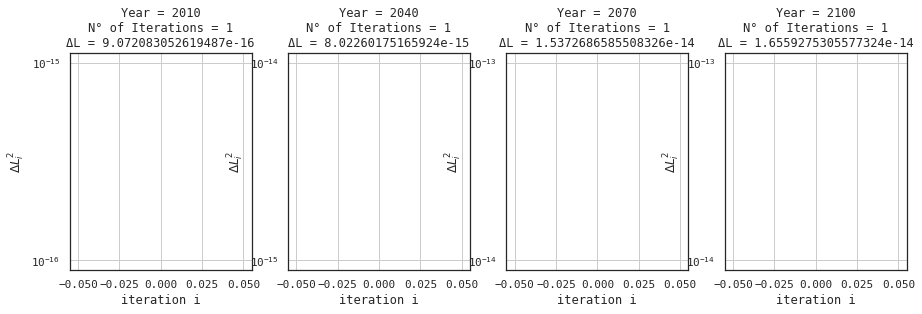

CPU times: user 19.3 s, sys: 889 ms, total: 20.2 s
Wall time: 19.3 s


In [21]:
%%time
m1 = model(name="intermediate, bilateral mig", tol=1e-5, scenario='intermediate')
m1.correct_south_south()
m1.calib_kappa()
m1.calib_A()
m1.calib_epsilon()
m1.calib_migcosts()
m1.fertility()
m1.simulate(report=True, report_from=0, max_iter=50,quickstart=True)
m1.urbanization()

## Model 2: Minimalist scenario full

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


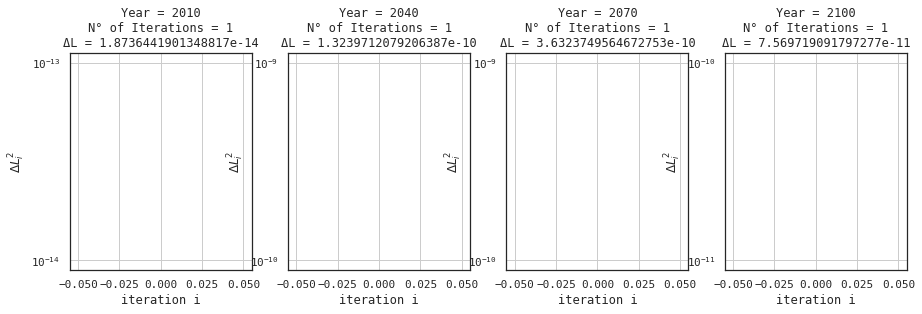

CPU times: user 19.9 s, sys: 265 ms, total: 20.2 s
Wall time: 20.2 s


In [22]:
%%time
m2 = model(name="minimalist, bilateral mig", tol=1e-5, scenario='minimalist')
m2.correct_south_south()
m2.calib_kappa()
m2.calib_A()
m2.calib_epsilon()
m2.calib_migcosts()
m2.fertility()
m2.simulate(report=True, report_from=0, max_iter=50,quickstart=True)
m2.urbanization()

## Model 3: Maximalist scenario full

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


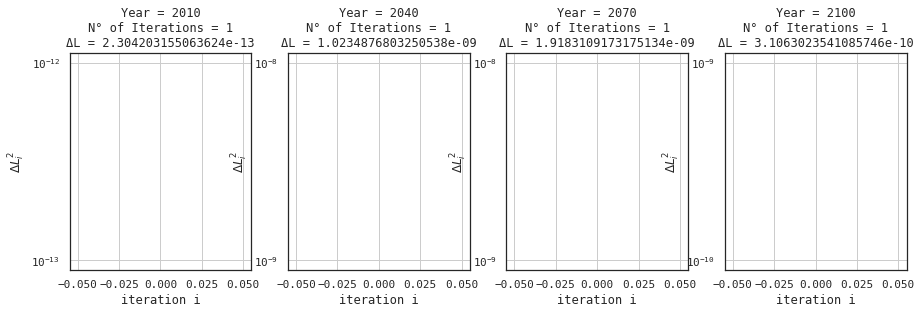

CPU times: user 18.5 s, sys: 222 ms, total: 18.8 s
Wall time: 18.8 s


In [23]:
%%time
m3 = model(name='maximalist, bilateral mig', tol=1e-5, scenario='maximalist')
m3.correct_south_south()
m3.calib_kappa()
m3.calib_A()
m3.calib_epsilon()
m3.calib_migcosts()
m3.fertility()
m3.simulate(report=True, report_from=0, max_iter=50,quickstart=True)
m3.urbanization()

## Model 4: Intermediate scenario no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


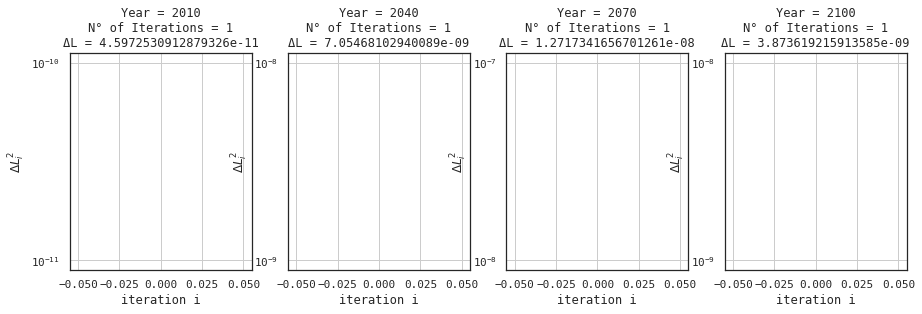

CPU times: user 18.6 s, sys: 228 ms, total: 18.8 s
Wall time: 18.8 s


In [26]:
%%time
m4 = model(name='intermediate no South', tol=1e-5, scenario='intermediate')
m4.calib_kappa()
m4.calib_A()
m4.calib_epsilon()
m4.calib_migcosts()
m4.fertility()
m4.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')
m4.urbanization()

## Model 5: Minimalist scenario no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


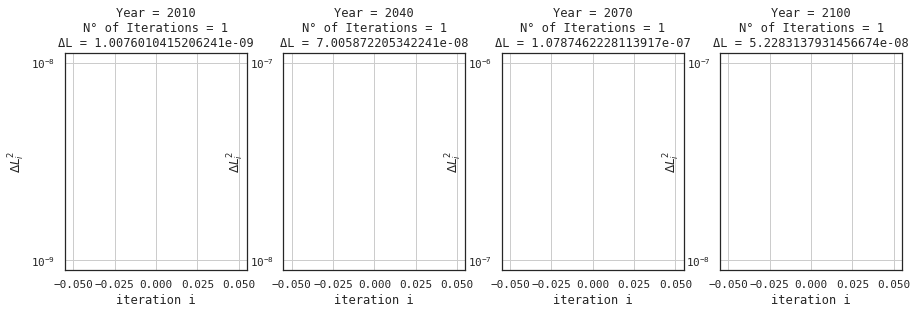

CPU times: user 18.9 s, sys: 196 ms, total: 19.1 s
Wall time: 19.1 s


In [27]:
%%time
m5 = model(name='minimalist no South', tol=1e-5, scenario='minimalist')
m5.calib_kappa()
m5.calib_A()
m5.calib_epsilon()
m5.calib_migcosts()
m5.fertility()
m5.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')
m5.urbanization()

## Model 6: Maximalist scenario no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


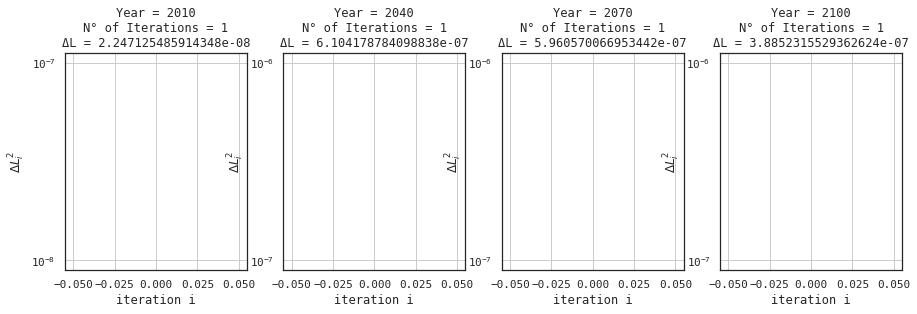

CPU times: user 19.2 s, sys: 200 ms, total: 19.4 s
Wall time: 19.4 s


In [28]:
%%time
m6 = model(name='maximalist no South', tol=1e-5, scenario='maximalist')
m6.calib_kappa()
m6.calib_A()
m6.calib_epsilon()
m6.calib_migcosts()
m6.fertility()
m6.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')
m6.urbanization()

## Model 7: Intermediate scenario no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


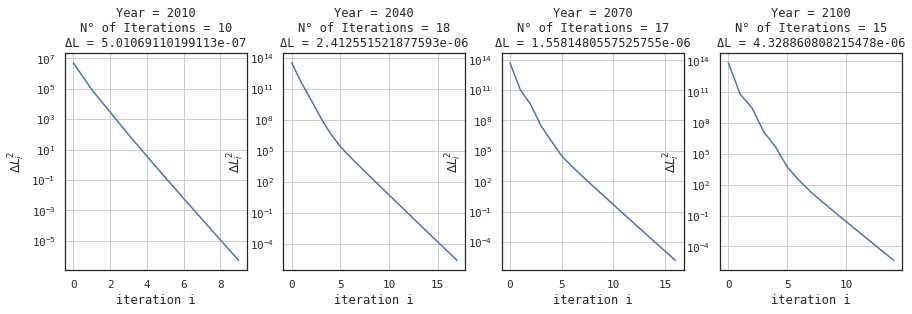

CPU times: user 1min 51s, sys: 380 ms, total: 1min 52s
Wall time: 1min 51s


In [29]:
%%time
m7 = model(name='intermediate no North', tol=1e-5, scenario='intermediate')
m7.calib_kappa()
m7.calib_A()
m7.calib_epsilon()
m7.calib_migcosts()
m7.fertility()
m7.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')
m7.urbanization()

## Model 8: Intermediate scenario no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


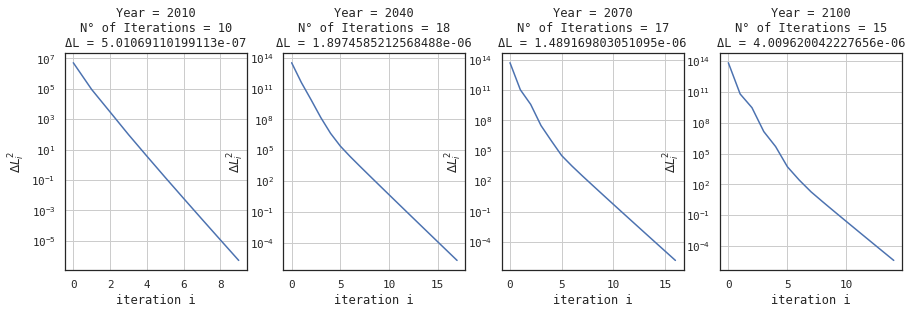

CPU times: user 1min 51s, sys: 399 ms, total: 1min 52s
Wall time: 1min 51s


In [30]:
%%time
m8 = model(name='minimalist no North', tol=1e-5, scenario='minimalist')
m8.calib_kappa()
m8.calib_A()
m8.calib_epsilon()
m8.calib_migcosts()
m8.fertility()
m8.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')
m8.urbanization()

## Model 9: Intermediate scenario no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


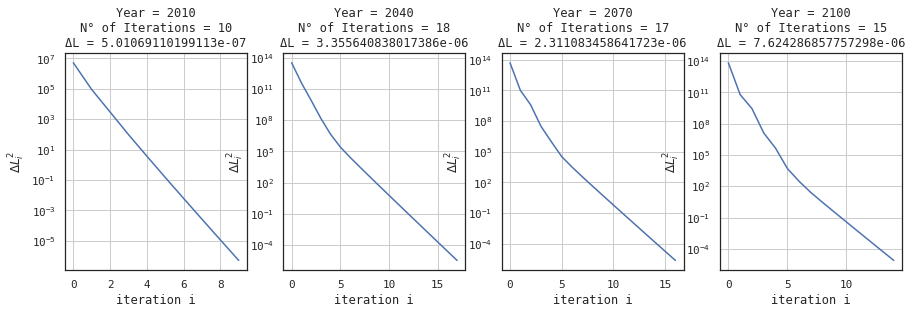

CPU times: user 1min 51s, sys: 334 ms, total: 1min 52s
Wall time: 1min 51s


In [31]:
%%time
m9 = model(name='maximalist no North', tol=1e-5, scenario='maximalist')
m9.calib_kappa()
m9.calib_A()
m9.calib_epsilon()
m9.calib_migcosts()
m9.fertility()
m9.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')
m9.urbanization()

## Model X: Intermediate scenario compensation for displacement

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


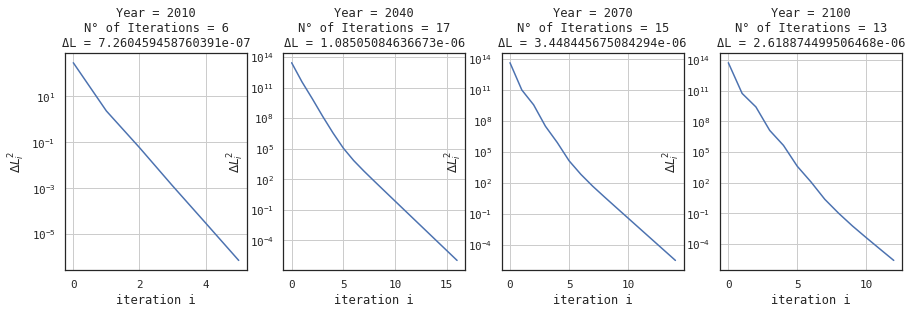

CPU times: user 1min 37s, sys: 369 ms, total: 1min 37s
Wall time: 1min 37s


In [32]:
%%time
m10 = model(name="intermediate, comp for forced displ", tol=1e-5, scenario='intermediate',χ={'d': 0.0, 'f': 0.0})
m10.correct_south_south()
m10.calib_kappa()
m10.calib_A()
m10.calib_epsilon()
m10.calib_migcosts()
m10.fertility()
m10.simulate(report=True, report_from=0, max_iter=50,quickstart=True)
m10.urbanization()

## Model X: Intermediate scenario proportional increase

/home/scheewel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


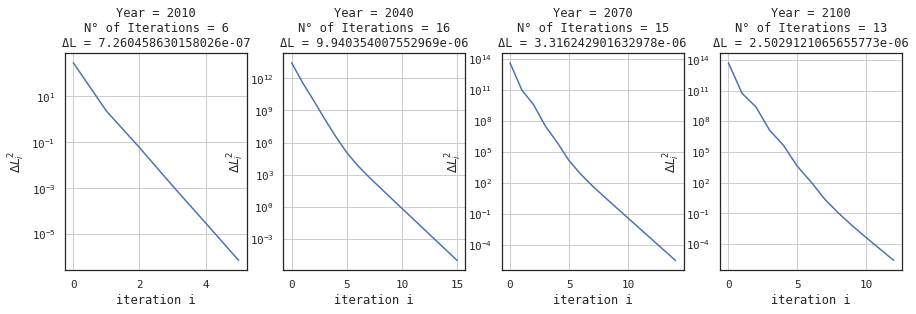

In [33]:
m11 = model(name="intermediate proportional increase", tol=1e-5, scenario='intermediate')
m11.correct_south_south()
m11.calib_kappa()
m11.calib_A()
m11.calib_epsilon()
m11.calib_migcosts()
m11.fertility()
m11.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proportional_increase')
m11.urbanization()

## Model X: Intermediate scenario proportional decrease

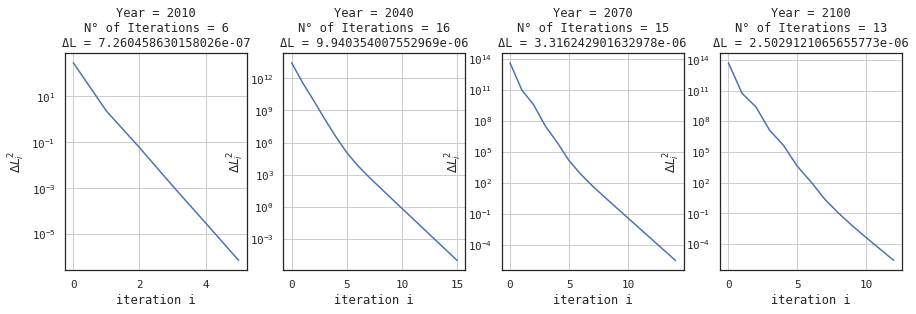

In [34]:
m12 = model(name="intermediate proportional decrease", tol=1e-5, scenario='intermediate')
m12.correct_south_south()
m12.calib_kappa()
m12.calib_A()
m12.calib_epsilon()
m12.calib_migcosts()
m12.fertility()
m12.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proportional_decrease')
m12.urbanization()

## Model X: Intermediate scenario no international

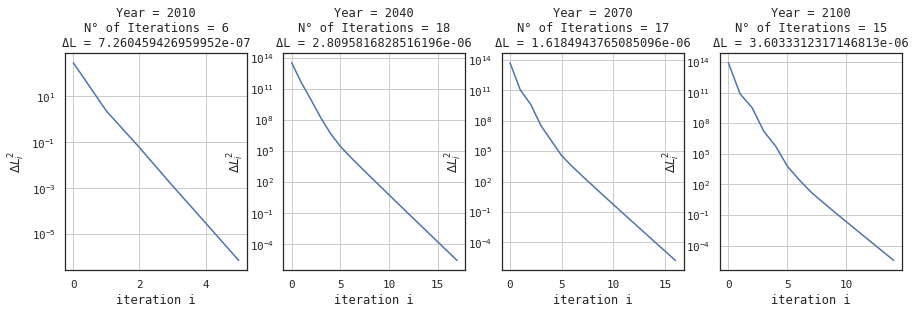

In [35]:
m13 = model(name="intermediate no international mig", tol=1e-5, scenario='intermediate')
m13.correct_south_south()
m13.calib_kappa()
m13.calib_A()
m13.calib_epsilon()
m13.calib_migcosts()
m13.fertility()
m13.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_international')
m13.urbanization()

## Model X: Intermediate scenario no internal

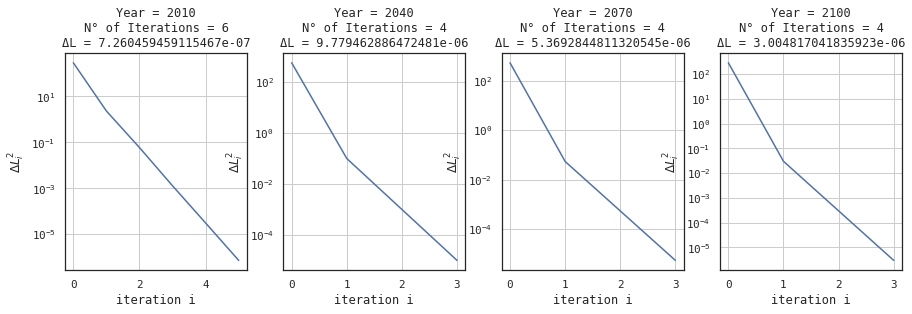

In [36]:
m14 = model(name="intermediate no internal mig", tol=1e-5, scenario='intermediate')
m14.correct_south_south()
m14.calib_kappa()
m14.calib_A()
m14.calib_epsilon()
m14.calib_migcosts()
m14.fertility()
m14.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_internal')
m14.urbanization()

## Model X: Intermediate scenario no migration

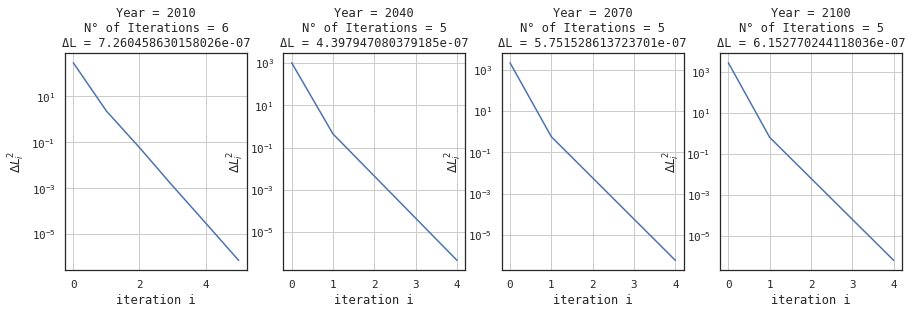

In [37]:
m15 = model(name="intermediate no mig", tol=1e-5, scenario='intermediate')
m15.correct_south_south()
m15.calib_kappa()
m15.calib_A()
m15.calib_epsilon()
m15.calib_migcosts()
m15.fertility()
m15.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no')
m15.urbanization()

# Clean up that mess

In [44]:
def world_stock_text_table(mod_int, mod_max, mod_min):
    int_min = (mod_int.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    max_min = (mod_max.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    int_min['Type'] = int_min.index
    int_min['Type'] = int_min.Type.str.split('-').apply(lambda x: x[-1])
    int_min = int_min.groupby('Type').sum()
    max_min['Type'] = max_min.index
    max_min['Type'] = max_min.Type.str.split('-').apply(lambda x: x[-1])
    max_min = max_min.groupby('Type').sum()

    return(round(pd.concat([int_min,max_min],0,keys=['int-min','max-min']),4))

In [45]:
def stackplot(mod_int_or_max,mod_min,drop=None,save=False,name='default.pdf'):
    matrix = (mod_int_or_max.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    matrix['Type'] = matrix.index
    matrix['Type'] = matrix.Type.str.split('-').apply(lambda x: x[-1])
    matrix = matrix.groupby('Type').sum()
    h = cycle(['','/','\\','|||'])
    if drop != None:
        mtx = matrix.drop(drop,0).sort_values(by=2040,ascending=False).T
    else:
        mtx = matrix.sort_values(by=2040,ascending=False).T
    cols = list(mtx)
    x = list(mtx.index)
    y = []
    hatches = []
    fig = plt.figure(figsize=[8,5])
    for col in cols:
        y = y + [list(mtx[col])]
        hatches = hatches + [next(h)]
    stacks = plt.stackplot(x,np.array(y),labels=cols,lw=1)
    #for stack in stacks:
    #    stack.set_hatch(next(h))
    plt.xticks(x)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=4)
    plt.tight_layout()
    plt.show()
    #display(mtx)
    if save != False:
        fig.savefig('graphs/stackplots/'+name)


In [46]:
#table = world_stock_text_table(m1, m3, m2)
table = world_stock_text_table(m7, m9, m8)

In [47]:
print(table.to_latex(bold_rows=True,multirow=True))

\begin{tabular}{llrrrr}
\toprule
        & \textbf{t} &  2010 &     2040 &     2070 &     2100 \\
{} & \textbf{Type} &       &          &          &          \\
\midrule
\multirow{4}{*}{\textbf{int-min}} & \textbf{Interregional} &   0.0 &   6.6353 &   7.3079 &   6.8170 \\
        & \textbf{Local} &   0.0 &  50.1143 &  61.9075 &  63.2581 \\
        & \textbf{North} &   0.0 &   0.0000 &   0.0000 &   0.0000 \\
        & \textbf{South} &   0.0 &   0.9217 &   1.2461 &   1.2694 \\
\cline{1-6}
\multirow{4}{*}{\textbf{max-min}} & \textbf{Interregional} &   0.0 &  17.2321 &  19.1525 &  16.9357 \\
        & \textbf{Local} &   0.0 &  59.5569 &  70.9190 &  72.4901 \\
        & \textbf{North} &   0.0 &   0.0000 &   0.0000 &   0.0000 \\
        & \textbf{South} &   0.0 &   0.8139 &   1.4907 &   1.5147 \\
\bottomrule
\end{tabular}



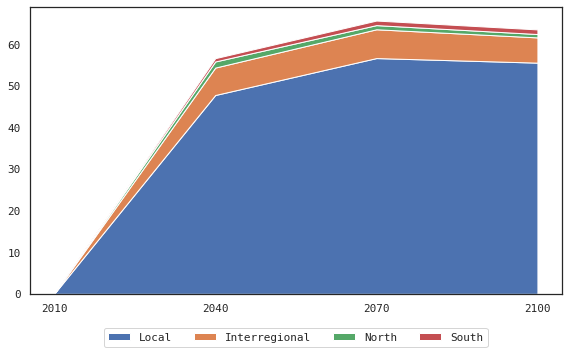

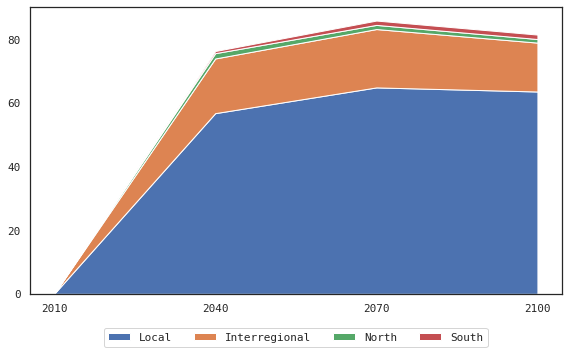

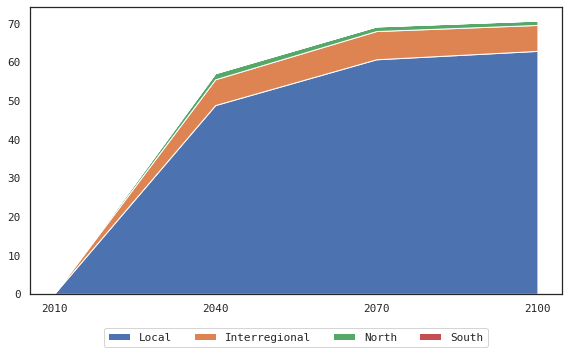

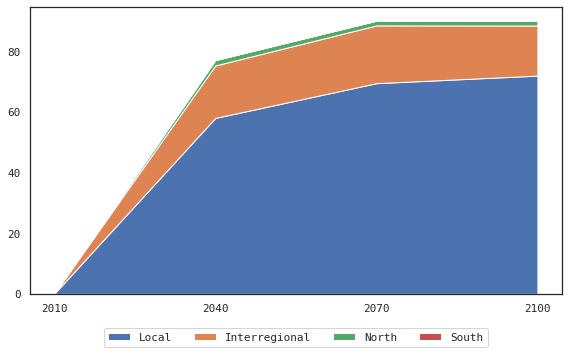

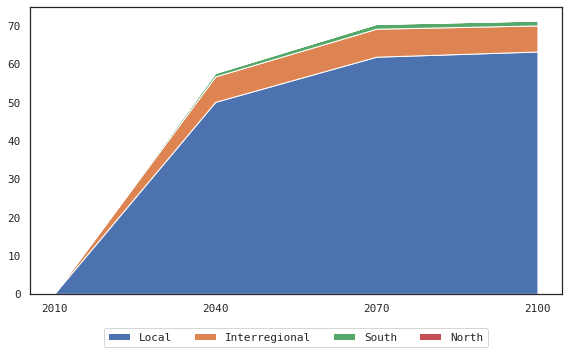

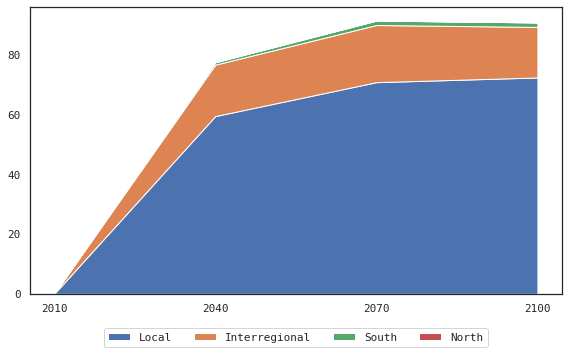

In [48]:
stackplot(m1,m2,save=True,name='int_min_full.pdf')
stackplot(m3,m2,save=True,name='max_min_full.pdf')
stackplot(m4,m5,save=True,name='int_min_nosouth.pdf')
stackplot(m6,m5,save=True,name='max_min_nosouth.pdf')
stackplot(m7,m8,save=True,name='int_min_nonorth.pdf')
stackplot(m9,m8,save=True,name='max_min_nonorth.pdf')


In [49]:
# b = False
# OECD = False

# dic = {
#     'Iij': 'International immigration',
#     'Iii': 'Internal immigration',
#     'Ms': 'Locally displaced people'}

# for var in ['Ms','Iij','Iii']:
#     for t in [2100]:
#         count = 0
#         for by in ['country','georegion','wbregion']:
#             for r in R:
#                 for s in S:
#                     count += 1
#                     fig = plt.figure(figsize=(25,7.5))
#                     a = m1.__dict__[var] - m2.__dict__[var]
#                     b = m3.__dict__[var] - m2.__dict__[var]
#                     c = m4.__dict__[var] - m5.__dict__[var]
#                     d = m6.__dict__[var] - m5.__dict__[var]

#                     if var == 'Ms':
#                         a = a.xs('f',1,2)
#                         b = b.xs('f',1,2)
#                         c = c.xs('f',1,2)
#                         d = d.xs('f',1,2)

#                     if OECD == True:
#                         a = a[m1.OECD == 1]
#                         b = b[m1.OECD == 1]
#                         c = c[m1.OECD == 1]
#                         d = d[m1.OECD == 1]

#                     if by != 'country':
#                         a.index = pd.Series(a.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         b.index = pd.Series(b.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         c.index = pd.Series(c.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         d.index = pd.Series(d.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))

#                         a = a.reset_index().groupby('Country').sum()
#                         b = b.reset_index().groupby('Country').sum()
#                         c = d.reset_index().groupby('Country').sum()
#                         d = d.reset_index().groupby('Country').sum()
#                     else:
#                         a.index = m1.iso
#                         b.index = m1.iso
#                         c.index = m1.iso
#                         d.index = m1.iso
                        
#                         fig = plt.figure(figsize=(25,7.5))
#                         plt.tick_params(axis='x', labelsize=8)

#                     if by == 'subregion':
#                         ms = 12
#                     if by == 'country':
#                         ms = 10

#                     plt.plot(a.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*1.0,label='bilateral migration, intermediate - minimalist')
#                     plt.plot(b.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.8,label='bilateral migration, maximalist - minimalist')
#                     plt.plot(c.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.6,label='only OECD migration, intermediate - minimalist')
#                     plt.plot(d.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.4,label='only OECD migration, maximalist - minimalist')
#                     plt.title("%s by %s, region = %s, skill = %s, year = %s"%(dic[var],by,r,s,t))
#                     rcParams.update({'figure.autolayout': True})
#                     plt.tight_layout()
#                     plt.xticks(rotation='vertical')
#                     plt.legend()
#                     plt.grid(ls=':')
#                     fig.savefig('graphs/movers/%s_%s_%s_%s.pdf' % (by,var,str(t),str(count)))
#                     plt.show()


In [57]:
def agg_ef_table(m,on='bddm'):
    tbl = out_world_aggregates(m,on).unstack(-2)[[2040,2070,2100]].swaplevel(1,0,1).stack().unstack().sort_index(0)
    return(tbl)

a = agg_ef_table(m2)
b = agg_ef_table(m1)-agg_ef_table(m2)
c = agg_ef_table(m1)-agg_ef_table(m2)
tab = pd.concat([a,b,c],0)

NameError: name 'm2' is not defined

In [111]:
tab

t                                    2010     2040     2070     2100
$\Delta$ Intermediate Local           0.0  47.8155  56.6999  55.5996
                      Interregional  -0.0   6.5987   6.9259   6.0737
                      North-North     0.0   0.7403   0.3797   0.2151
                      North-South     0.0   0.0540   0.0241   0.0135
                      South-North     0.0   0.7285   0.6236   0.5932
                      South-South     0.0   0.7399   1.0731   1.0987
$\Delta$ Maximalist   Local           0.0  56.8372  64.9354  63.6489
                      Interregional  -0.0  17.2069  18.3615  15.3820
                      North-North     0.0   0.9832   0.4911   0.2757
                      North-South     0.0   0.0707   0.0299   0.0166
                      South-North     0.0   0.6821   0.8152   0.8526
                      South-South     0.0   0.6079   1.3388   1.3843

In [ ]:
(m0.L*m0.w).unstack().reset_index().groupby(['Country','r','t']).sum()[0].unstack([1,2]).to_excel('bla.xlsx')

In [ ]:
(m0.L.xs(1980,1,2)*m0.w.xs(1980,1,2))

In [ ]:
(m0.L * m0.w).reset_index()

In [108]:
round(out_world_aggregates(m0),1)

t,1980,2010,2040,2070,2100
Population in 10000000.0,163.0,305.7,382.0,431.6,472.1
Urban Share in \%,41.4,53.0,57.6,59.5,58.6
HS Share in \%,3.8,8.8,15.1,18.1,19.4
GDP per Worker,17861.5,24819.5,24331.2,26700.0,29306.9
GDP in 10000000000.0 \$US,2911.7,7587.5,9293.8,11522.4,13834.6


In [109]:
round(out_world_aggregates(m1),1)

t,1980,2010,2040,2070,2100
Population in 10000000.0,163.0,313.4,374.0,396.8,414.2
Urban Share in \%,41.4,54.1,56.8,56.4,54.5
HS Share in \%,3.8,9.0,23.0,23.3,22.5
GDP per Worker,6181.8,9633.1,20802.1,20195.6,19652.1
GDP in 10000000000.0 \$US,1007.7,3019.4,7779.3,8012.5,8139.1


In [ ]:
GDP = m1.out_world_aggregates('Country').T['GDP p. C.'].loc[2100]-m2.out_world_aggregates('Country').T['GDP p. C.'].loc[2100]

In [ ]:
plt.scatter(GDP,m1.latitude)
plt.show()

# Result section

## Constant moving costs : Comparison between climate scenarios (i.e. climate migrants)

### World stock of climate migrant by type (local, interregional, South-South, South-North) for 2 scenarios

In [104]:
minim = m2.out_migrant_world_stock()
inter = round(m1.out_migrant_world_stock()-minim,4)
maxim = round(m3.out_migrant_world_stock()-minim,4)

tab = pd.concat([inter,maxim],0,keys=['$\Delta$ Intermediate','$\Delta$ Maximalist'])
tab.unstack(0).swaplevel(0,0,1).T.sort_index().T

t                              2010                                      2040  \
              $\Delta$ Intermediate $\Delta$ Maximalist $\Delta$ Intermediate   
Local                           0.0                 0.0               47.8155   
Interregional                  -0.0                -0.0                6.5987   
North-North                     0.0                 0.0                0.7403   
North-South                     0.0                 0.0                0.0540   
South-North                     0.0                 0.0                0.7285   
South-South                     0.0                 0.0                0.7399   

t                                                  2070                      \
              $\Delta$ Maximalist $\Delta$ Intermediate $\Delta$ Maximalist   
Local                     56.8372               56.6999             64.9354   
Interregional             17.2069                6.9259             18.3615   
North-North                0.9832                0.3797              0.4911   
North-South                0.0707                0.0241              0.0299   
South-North                0.6821                0.6236              0.8152   
South-South                0.6079                1.0731              1.3388   

t                              2100                      
              $\Delta$ Intermediate $\Delta$ Maximalist  
Local                       55.5996             63.6489  
Interregional                6.0737             15.3820  
North-North                  0.2151              0.2757  
North-South                  0.0135              0.0166  
South-North                  0.5932              0.8526  
South-South                  1.0987              1.3843

### DWorld distribution of income~/DWorld dist. of utility (accounting for 1-x)~ (in the 2 scenarios)

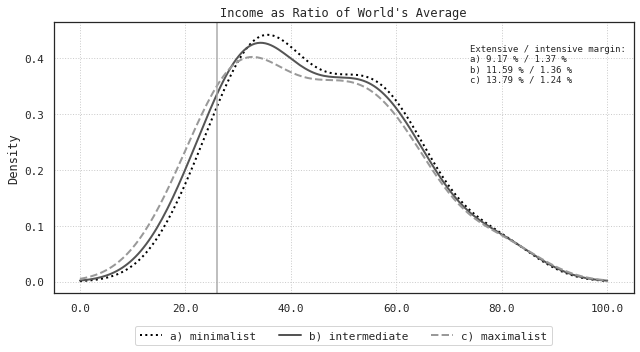

In [57]:
m2.out_distplot([m1,m3],text=True,save=True,save_name='Fig7.pdf',cols=3)

### Changes in mover stocks by region of origin w.r.t. Minimalist (one graph per region, local, intern, to S, to N)

### Changes in mover stocks by region of destin. w.r.t. Minimalist (one graph per region, local, intern, from S, from N)

## TFP changes

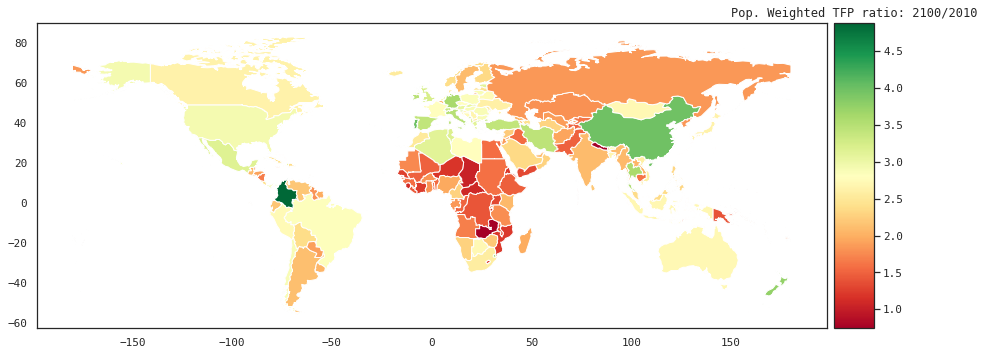

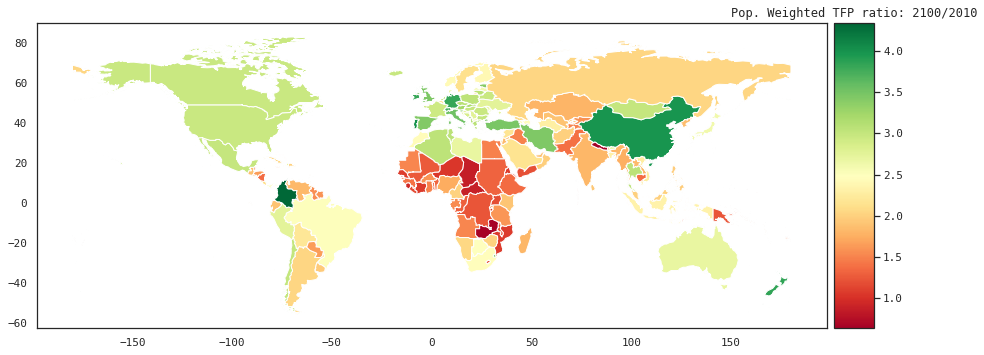

In [175]:
for m in [m1,m3]:
    A = m.A
    Lr = m.L.unstack().reset_index().groupby(['r','t','Country']).sum()[0].unstack([0,1])
    L = m.L.unstack().reset_index().groupby(['t','Country']).sum()[0].unstack().T
    L = pd.concat([L,L],1,keys=['a','n'],names=['r','t'])

    TFP = (A*(Lr/L)).unstack().reset_index().groupby(['t','Country']).sum().unstack(0)[0][[2010,2100]]
    TFP['ratio'] = TFP[2100]/TFP[2010]
    TFP = TFP.join(m.iso)
    TFP = TFP.sort_values('ratio')
    stats = round(TFP.ratio.describe(),4)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(15, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    m.shapes.join(TFP.ratio).plot('ratio',figsize=(20,10), ax=ax, legend=True, cax=cax,cmap='RdYlGn')
    plt.title('Pop. Weighted TFP ratio: 2100/2010')
    display(HTML('<b>%s $(\mu = %s$, $\sigma =  %s)$</b>' % (m.name,str(stats['mean']),str(stats['mean']))))
    plt.show()

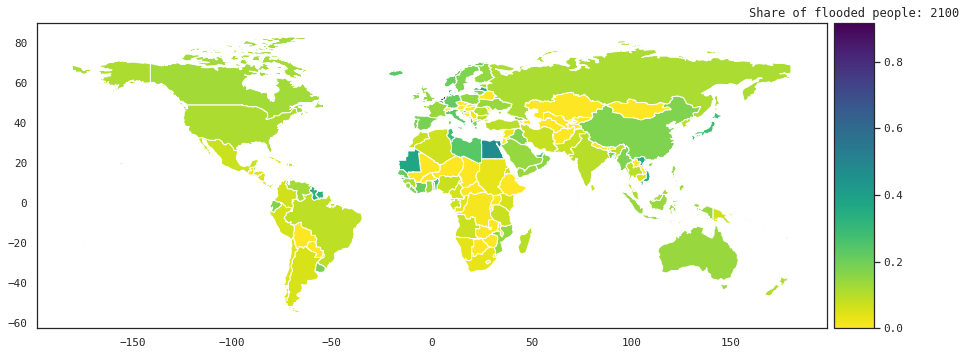

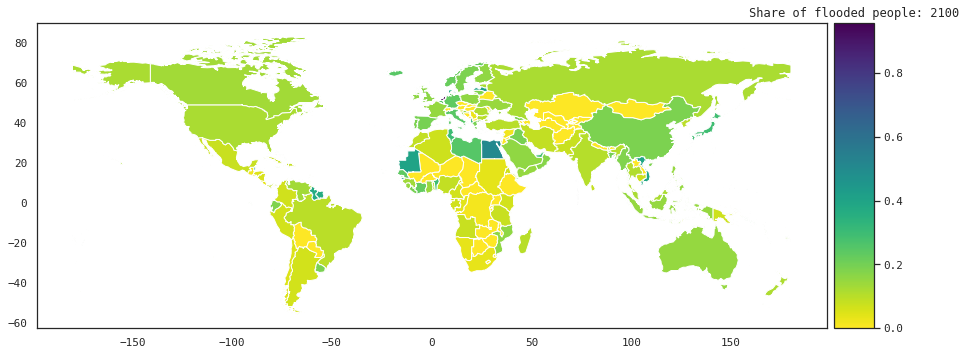

In [170]:
for m in [m1,m3]:
    N = m.N.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([0,1])[0].xs(2100,1,1)
    ω = m.ω.xs(2100,1,1)
    df = pd.DataFrame((N * ω).sum(1)/N.sum(1))
    stats = round(df[0].describe(),4)
    df[0] = (df[0])**(1/2)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(15, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    m.shapes.join(df).plot(0,figsize=(20,10), ax=ax, legend=True, cax=cax,cmap='viridis_r')
    plt.title('Share of flooded people: 2100')
    display(HTML('<b>%s $(\mu = %s$, $\sigma =  %s)$</b>' % (m.name,str(stats['mean']),str(stats['mean']))))
    plt.show()
    print()

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
print(viridis)

## Effect of migration policies (closed borders vs same relative change in (1-x) for Urb, mig to S, mig to N)

### In the 3 scenarios: DWorld distribution of income~/DWorld dist. of utility (accounting for 1-x)~

## Compensating forcibly displaced people

### Effect of xrr=0: World distribution of income~/World dist. of utility (accounting for 1-x)~

# Appendix
Focus on the Intermediate scenario (as in Appendix C of my JDE paper: https://ars.els-cdn.com/content/image/1-s2.0-S0304387819302780-mmc1.pdf)

### Table with World Aggregates in 2010, 2040, 2070, 2100 (cols): Population, Share of urban, Share of Colle grads, GDP per capita (rows).

In [56]:
display(m1.out_world_aggregates())
display(m1.out_world_aggregates(on='georegion'))

t,1980,2010,2040,2070,2100
Population in 10000000.0,163.01,313.44,373.97,396.75,414.16
Urban Share in \%,41.41,54.14,56.76,56.42,54.52
HS Share in \%,3.79,8.97,23.01,23.31,22.49
GDP per Worker,6181.83,9633.07,20802.08,20195.62,19652.09
GDP in 10000000000.0 \$US,1007.72,3019.39,7779.29,8012.53,8139.06


t                                        1980      2010      2040      2070  \
                          georegion                                           
Population in 10000000.0  Africa        14.62     35.26     69.85    116.52   
                          Americas      23.00     43.25     49.30     43.86   
                          Asia          92.89    194.96    221.61    210.63   
                          Europe        31.59     38.37     31.24     23.67   
                          Oceania        0.91      1.60      1.97      2.06   
Urban Share in \%         Africa        27.04     41.85     40.73     40.52   
                          Americas      69.16     79.81     85.57     88.85   
                          Asia          27.62     46.63     52.09     55.34   
                          Europe        67.43     73.83     79.41     83.63   
                          Oceania       74.65     73.70     70.70     62.44   
HS Share in \%            Africa         0.79      3.34      7.10      7.14   
                          Americas      10.49     17.87     49.29     53.21   
                          Asia           1.99      6.14     18.08     22.23   
                          Europe         5.38     18.06     50.40     55.21   
                          Oceania       11.55     19.74     49.36     45.15   
GDP per Worker            Africa       913.27   2365.67   3545.92   3649.67   
                          Americas   17156.73  25451.04  65024.30  74685.99   
                          Asia        2384.86   4610.48   9159.93  10493.76   
                          Europe     11240.85  22766.10  67413.23  80359.89   
                          Oceania    25302.99  39195.11  96450.89  96555.33   
GDP in 10000000000.0 \$US Africa        13.35     83.40    247.68    425.26   
                          Americas     394.64   1100.84   3205.69   3275.62   
                          Asia         221.53    898.87   2029.92   2210.35   
                          Europe       355.12    873.47   2105.72   1902.00   
                          Oceania       23.09     62.81    190.28    199.30   

t                                        2100  
                          georegion            
Population in 10000000.0  Africa       180.20  
                          Americas      36.07  
                          Asia         177.56  
                          Europe        18.17  
                          Oceania        2.16  
Urban Share in \%         Africa        39.84  
                          Americas      91.28  
                          Asia          58.55  
                          Europe        87.72  
                          Oceania       54.26  
HS Share in \%            Africa         6.77  
                          Americas      58.15  
                          Asia          27.17  
                          Europe        59.84  
                          Oceania       40.36  
GDP per Worker            Africa      3646.11  
                          Americas   90007.02  
                          Asia       12525.13  
                          Europe     99514.47  
                          Oceania    94386.63  
GDP in 10000000000.0 \$US Africa       657.03  
                          Americas    3246.49  
                          Asia        2223.98  
                          Europe      1807.89  
                          Oceania      203.66

- [ ] Figure with region shares in 2010, 2040, 2070, 2100: in Population, in Urban population, in College-educated population, in total GDP (4 sub-figures)

- [ ] Table with Emigration rates by Region in 2010, 2040, 2070, 2100 (cols): all regions (rows)

In [ ]:
m1.out_emigration_rate_by_wbregion()

- [ ] Table with Immigration rates by Region in 2010, 2040, 2070, 2100 (cols): all regions (rows)

In [ ]:
m1.out_immigration_rate_by_country()

- [ ] Figures with decomposition of mover stocks in 2010, 2040, 2070, 2100: one figure per region of origin; shares of local, interregional, international S-S, international S-N

- [ ] Figures with decomposition of mover stocks in 2010, 2040, 2070, 2100: one figure per region of destination; shares of local, interregional, S-S, S-N

- [ ] In the Minimalist scenario: World distribution of income  / World dist. of utility (accounting for 1-x)

# Additional plots & tables

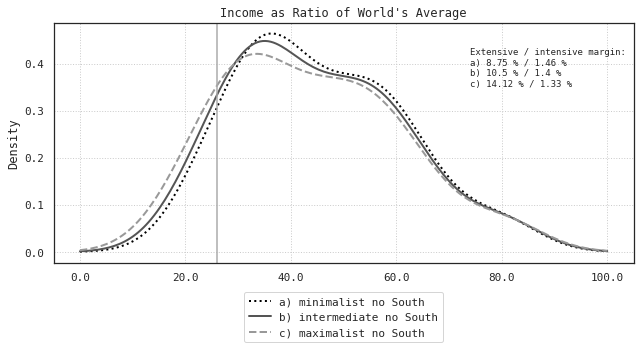

In [38]:
m5.out_distplot([m4,m6],text=True,save=True,save_name='nosouth.pdf')

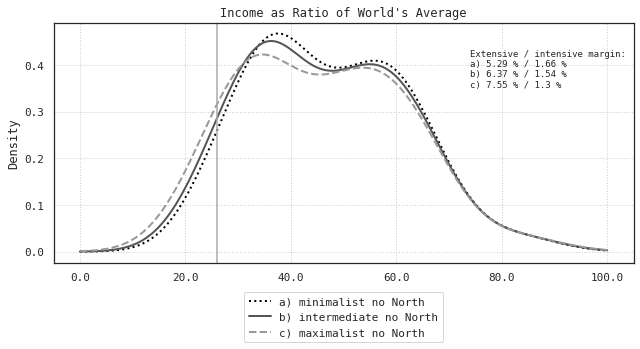

In [39]:
m8.out_distplot([m7,m9],text=True,save=True,save_name='nonorth.pdf')

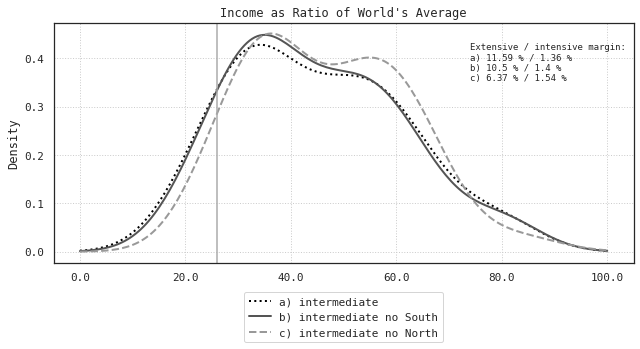

In [40]:
m1.out_distplot([m4,m7],text=True,save=True,save_name='full_nosouth_nonorth.pdf')

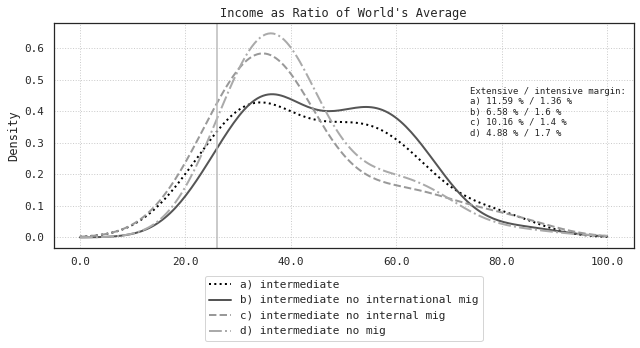

In [41]:
m1.out_distplot([m13,m14,m15],text=True,save=True,save_name='closing_borders.pdf')

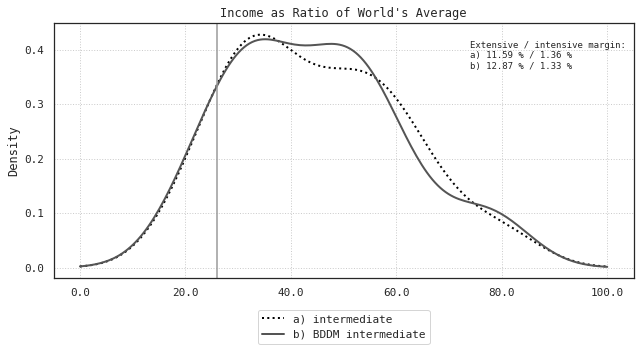

In [42]:
m1.out_distplot([m0],text=True,save=True,save_name='BDSvsBDDM.pdf')

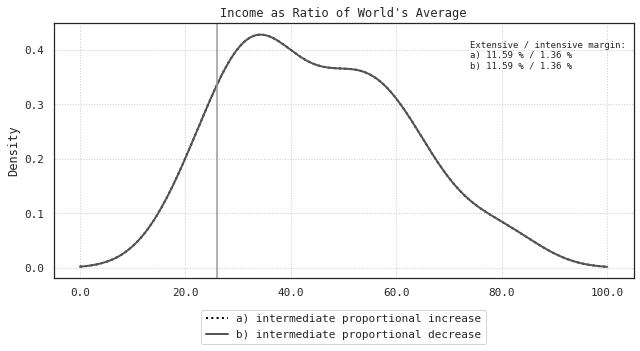

In [43]:
m11.out_distplot([m12],text=True)

In [59]:
m1.out_world_aggregates('income_group')

t                                           1980      2010       2040  \
                          income_group                                  
Population in 10000000.0  HIC              38.97     54.49      52.08   
                          LIC               8.59     19.80      33.50   
                          LMC              50.49    111.92     162.97   
                          UMC              64.96    127.23     125.42   
Urban Share in \%         HIC              72.68     80.50      87.29   
                          LIC              23.41     37.70      34.51   
                          LMC              26.47     38.08      40.12   
                          UMC              36.64     59.53      71.65   
HS Share in \%            HIC               9.29     20.65      59.44   
                          LIC               1.65      6.46       5.63   
                          LMC               1.92      6.03      13.40   
                          UMC               2.22      6.95      25.01   
GDP per Worker            HIC           21022.90  38923.29  109350.64   
                          LIC            1090.17   3198.84    2849.75   
                          LMC             713.69   1703.81    2758.57   
                          UMC            2202.62   5065.31   12276.88   
GDP in 10000000000.0 \$US HIC             819.23   2120.89    5694.46   
                          LIC               9.37     63.34      95.46   
                          LMC              36.03    190.69     449.57   
                          UMC             143.09    644.47    1539.80   

t                                            2070       2100  
                          income_group                        
Population in 10000000.0  HIC               43.93      36.83  
                          LIC               56.92      99.56  
                          LMC              189.10     194.27  
                          UMC              106.79      83.49  
Urban Share in \%         HIC               90.94      93.59  
                          LIC               32.88      31.97  
                          LMC               43.23      46.59  
                          UMC               78.10      82.63  
HS Share in \%            HIC               62.17      65.36  
                          LIC                4.42       3.54  
                          LMC               15.63      17.78  
                          UMC               30.99      37.14  
GDP per Worker            HIC           125815.92  146468.29  
                          LIC             1893.75    1561.96  
                          LMC             3468.50    4430.92  
                          UMC            16117.41   20698.85  
GDP in 10000000000.0 \$US HIC             5527.70    5394.59  
                          LIC              107.80     155.51  
                          LMC              655.90     860.81  
                          UMC             1721.14    1728.14

# Experimental

In [ ]:
var = ['A','D','Γ__L']
df = pd.concat([self.__dict__[v] for v in var],axis=1,keys=var)
df.columns.names = ['Variable','r','t']
df = df.unstack().reset_index()
df = df[(df['t'] == 2010) | (df['t'] == 1980)]
df['t'] = df.t.replace([1980,2010],[0,1])
df = df.set_index(['Country','Variable','r','t'])[0].unstack(level=[1,2])
#df = df.reset_index(level=1)

In [ ]:
df = df.xs(r,1,1)
df = df.reset_index(level=1)

In [ ]:
reg = sm.ols(formula="np.log(A) - np.log(D) ~ np.log(Γ__L) + t",data=df).fit()

In [ ]:
reg.params['t']

In [ ]:
%%time
m1 = model(name="intermediate, bilateral mig", tol=1e-5, scenario='intermediate')
m1.correct_south_south()
m1.calib_kappa()
m1.calib_A()

self = m1
self.ε = {'a': np.nan, 'n': np.nan}             # aggregate externality
self.A_bar = pd.DataFrame(index=self.countries) # scale factor in TFP

A_D = pd.concat([m1.A.xs(1980,1,1)/m1.D.xs(1980,1,1),m1.A.xs(2010,1,1)/m1.D.xs(2010,1,1)],1,keys=[1980,2010]).swaplevel(1,0,1)

df = pd.concat([self.A,self.Γ__L],1,keys=['A','Γ__L'])

def reg(r):
    df = self.A[r].melt(var_name='year2010',value_name='A')
    df = df.join(self.Γ__L[r].melt(var_name='year2010'
                                   ,value_name='Γ__L')['Γ__L'])
    df['year2010'] = np.where(df.year2010 == 2010,1,0)

    reg = sm.ols(formula="np.log(A) ~ np.log(Γ__L) + year2010", 
                 data=df).fit()

    return(reg.params)

self.γ = reg('a')['year2010'] ** (1/30)
self.γ = 1.00256317290118    

t = 2010
for r in R:
    self.ε[r] = 0.5 * reg(r)['np.log(Γ__L)']
    self.A_bar[r] = self.A[(r,t)]/(self.γ * self.Γ__L[(r,t)]**self.ε[r] * self.D[(r,t)])

In [ ]:
self.ε

In [ ]:
m1.γ